# Business Understanding

In an effort to make educational investments less speculative, the US Department of Education has matched information from the student financial aid system with federal tax returns to create the College Scorecard dataset.

This dataset contains a wide range of college features including academics, admissions, student demographics, cost, financial aid, completion %'s, repayment, and earnings. 

This project looks at the 'Percent completed within 4 years at original institution' [COMP_ORIG_YR4_RT] and see which features have the strongest correlations from the dataset.

# Data Understanding

The dataset is large and contains data ranging back from 1998. The dataset is limited to the last five years to reduce the running time for the code below. For every column, 'PrivacySuppressed' values were converted to NaN values.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
np.random.seed(9)

In [2]:
# Connect to SQLite file

conn = sqlite3.connect('data/database.sqlite')
cur = conn.cursor()

In [3]:
# Create connection and check table names

cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")

table_names = cur.fetchall()
table_names

[('Scorecard',)]

An initial dataframe was created of currently operating schools that grant predominantly associate's and bachelor's degrees from 2007 to 2012.

This dataframe will be used to find the top correlated features for each category.

In [5]:
df = pd.read_sql("""
SELECT * 
FROM Scorecard 
WHERE year BETWEEN 2007 AND 2012
AND CURROPER = "Currently certified as operating"
AND PREDDEG in ("Predominantly bachelor's-degree granting", 
                "Predominantly associate's-degree granting")
;
""", conn, index_col='Id')

In [6]:
# Confirm SQL query year range

df['Year'].unique()

array([2007, 2008, 2009, 2010, 2011, 2012], dtype=int64)

In [7]:
#  Check the dataframe's shape

df.shape

(19509, 1730)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19509 entries, 73000 to 116507
Columns: 1730 entries, UNITID to Year
dtypes: float64(191), int64(193), object(1346)
memory usage: 257.6+ MB


In [9]:
df.head(5)

UNITID    OPEID  opeid6                               INSTNM  \
Id                                                                    
73000  100654   100200    1002             Alabama A & M University   
73001  100663   105200    1052  University of Alabama at Birmingham   
73002  100690  2503400   25034                   Amridge University   
73003  100706   105500    1055  University of Alabama in Huntsville   
73004  100724   100500    1005             Alabama State University   

             CITY STABBR         ZIP AccredAgency INSTURL NPCURL  sch_deg  \
Id                                                                          
73000      Normal     AL       35762         None    None   None      3.0   
73001  Birmingham     AL  35294-0110         None    None   None      3.0   
73002  Montgomery     AL  36117-3553         None    None   None      3.0   
73003  Huntsville     AL       35899         None    None   None      3.0   
73004  Montgomery     AL  36101-0271         None    None   None      3.0   

       HCM2         main  NUMBRANCH                                   PREDDEG  \
Id                                                                              
73000     0  Main campus          1  Predominantly bachelor's-degree granting   
73001     0  Main campus          1  Predominantly bachelor's-degree granting   
73002     0  Main campus          1  Predominantly bachelor's-degree granting   
73003     0  Main campus          1  Predominantly bachelor's-degree granting   
73004     0  Main campus          1  Predominantly bachelor's-degree granting   

               HIGHDEG            CONTROL  st_fips  \
Id                                                   
73000  Graduate degree             Public  Alabama   
73001  Graduate degree             Public  Alabama   
73002  Graduate degree  Private nonprofit  Alabama   
73003  Graduate degree             Public  Alabama   
73004  Graduate degree             Public  Alabama   

                                                  region LOCALE locale2  \
Id                                                                        
73000  Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC,...   None    None   
73001  Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC,...   None    None   
73002  Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC,...   None    None   
73003  Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC,...   None    None   
73004  Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC,...   None    None   

      LATITUDE LONGITUDE CCBASIC CCUGPROF CCSIZSET  HBCU   PBI ANNHI TRIBAL  \
Id                                                                            
73000     None      None    None     None     None  None  None  None   None   
73001     None      None    None     None     None  None  None  None   None   
73002     None      None    None     None     None  None  None  None   None   
73003     None      None    None     None     None  None  None  None   None   
73004     None      None    None     None     None  None  None  None   None   

      AANAPII   HSI NANTI MENONLY WOMENONLY RELAFFIL  ADM_RATE  ADM_RATE_ALL  \
Id                                                                             
73000    None  None  None    None      None     None    0.3182        0.3182   
73001    None  None  None    None      None     None    0.8778        0.8778   
73002    None  None  None    None      None     None       NaN           NaN   
73003    None  None  None    None      None     None    0.8800        0.8800   
73004    None  None  None    None      None     None    0.4159        0.4159   

       SATVR25  SATVR75  SATMT25  SATMT75  SATWR25  SATWR75  SATVRMID  \
Id                                                                      
73000      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
73001    470.0    620.0    500.0    650.0      NaN      NaN     545.0   
73002      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
73003    490.0  

In [10]:
# Convert all 'PrivacySuppressed' values to NaN values

df = df.replace('PrivacySuppressed', np.nan, regex=True)

### [COMP_ORIG_YR4_RT] - Target Variable

The target variable contains NaN's which must be handled with. Upon inspection, many of the colleges with NaN's were community or religious training colleges. The NaN's make up more than 5% so cant' be dropped and will instead be replaced using the median values of that column.

In [11]:
df['COMP_ORIG_YR4_RT'].isna().sum()

1276

In [12]:
explore = df[df['COMP_ORIG_YR4_RT'].isnull()]
explore['INSTNM'].value_counts()

Central Yeshiva Tomchei Tmimim Lubavitz                               6
Community Christian College                                           6
Ner Israel Rabbinical College                                         6
Great Lakes Christian College                                         6
Pacific States University                                             6
Beacon College                                                        6
Baptist University of the Americas                                    6
International Baptist College                                         6
Heritage Christian University                                         6
Heritage Bible College                                                6
American Baptist College                                              6
Imperial Valley College                                               6
Southern California Seminary                                          6
Christian Life College                                          

In [13]:
# Checking the NaN Count and percent
X_NaN = df['COMP_ORIG_YR4_RT'].isna().sum()
X_len = len(df['COMP_ORIG_YR4_RT'])
X_NaN, X_len, X_NaN / X_len

(1276, 19509, 0.0654057101850428)

In [14]:
df['COMP_ORIG_YR4_RT'] = df['COMP_ORIG_YR4_RT'].fillna(df['COMP_ORIG_YR4_RT'].median())

In [15]:
df['COMP_ORIG_YR4_RT'].isna().sum()

0

In [16]:
df['COMP_ORIG_YR4_RT'].value_counts()

0.334320    1278
0.000000     393
0.319006     119
0.343499     108
0.312364      98
0.188030      52
0.500000      50
0.201995      47
0.227174      45
0.227570      42
0.186091      28
0.353503      27
0.155505      27
0.151715      23
0.367829      23
0.126709      22
0.555874      21
0.561854      20
0.555657      20
0.538769      20
0.547874      20
0.556736      20
0.290266      18
0.060040      18
0.230065      18
1.000000      18
0.095759      18
0.202713      17
0.134772      16
0.207602      16
0.666667      16
0.268888      16
0.112562      16
0.160834      15
0.269844      15
0.300786      15
0.052134      15
0.303820      15
0.146334      15
0.041446      14
0.165365      14
0.400000      14
0.207941      14
0.300174      13
0.250000      13
0.164001      13
0.332216      12
0.600000      12
0.178109      12
0.215486      12
0.149029      12
0.333333      12
0.428571      11
0.142180      11
0.170094      11
0.750000      11
0.478261      11
0.444444      10
0.130040      

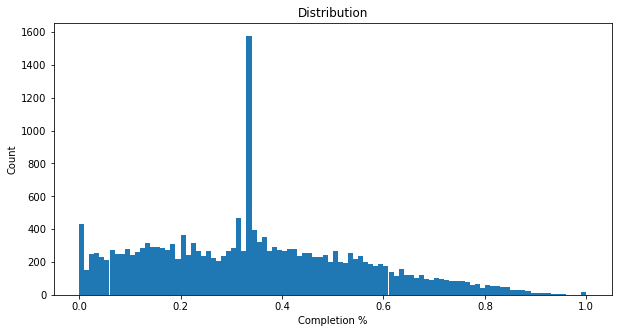

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df['COMP_ORIG_YR4_RT'], bins=100)

ax.set_xlabel("Completion %")
ax.set_ylabel("Count")
ax.set_title("Distribution");

In [18]:
# Create new dataframe after NaN's have been replaced with median

processed_df = df

# Feature Variables

Many of the feature variables also contain NaN's values in their columns. In order to narrow the search for a strong correlation, columns will be dropped if they contain only NaN's. For other columns that have data for other years, the median for that institution will replace the NaN values. In addition, columns that have outdated or duplicate data will be dropped. Finally, any remaining NaN values will be filled in with a KNN imputer. 

This process will be done for each feature category: school, admissions, academics, student, cost, aid, completion, repayment, and earning features. The top 5 features from each category will be added to a list to create a new dataframe which will be used for modelling.

In [19]:
# look at columns w NaN's
processed_df.isna().sum()

UNITID                                  0
OPEID                                   0
opeid6                                  0
INSTNM                                  0
CITY                                    0
STABBR                                  0
ZIP                                     0
AccredAgency                        19509
INSTURL                             19509
NPCURL                              19509
sch_deg                                12
HCM2                                    0
main                                    0
NUMBRANCH                               0
PREDDEG                                 0
HIGHDEG                                 0
CONTROL                                 0
st_fips                                 0
region                                  0
LOCALE                              19509
locale2                             19509
LATITUDE                            19509
LONGITUDE                           19509
CCBASIC                           

In [20]:
# remove columns with all NaN's

perc = 100.0 # Like N %
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
processed_df = processed_df.dropna( axis=1, thresh=min_count)

In [21]:
# Recheck dataset size after dropping 100% NaN columns

processed_df.shape

(19509, 1626)

In [22]:
# Inspect other columns with NaN'

processed_df.isna().sum()

UNITID                                  0
OPEID                                   0
opeid6                                  0
INSTNM                                  0
CITY                                    0
STABBR                                  0
ZIP                                     0
sch_deg                                12
HCM2                                    0
main                                    0
NUMBRANCH                               0
PREDDEG                                 0
HIGHDEG                                 0
CONTROL                                 0
st_fips                                 0
region                                  0
ADM_RATE                             8218
ADM_RATE_ALL                         7658
SATVR25                             12045
SATVR75                             12045
SATMT25                             11954
SATMT75                             11954
SATWR25                             15341
SATWR75                           

In [23]:
# drop irrelevant or duplicate columns

irrelevant_columns = ['OPEID','opeid6', 'sch_deg', 'HCM2', 'UGDS_AIANOld', 'UGDS_HISPOld', 'C150_4_AIANOld', 'C150_4_HISPOld', 'C150_L4_AIANOld', 'C150_L4_HISPOld']

processed_df = processed_df.drop(irrelevant_columns, axis=1)
processed_df.shape

(19509, 1616)

# School Features

In [24]:
# list of school features

school_features = ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'main', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'st_fips', 'region', 'Year', 'COMP_ORIG_YR4_RT']
school_df = processed_df[school_features].copy()

In [25]:
school_df.isna().sum()

UNITID              0
INSTNM              0
CITY                0
STABBR              0
ZIP                 0
main                0
NUMBRANCH           0
PREDDEG             0
HIGHDEG             0
CONTROL             0
st_fips             0
region              0
Year                0
COMP_ORIG_YR4_RT    0
dtype: int64

In [26]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19509 entries, 73000 to 116507
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UNITID            19509 non-null  int64  
 1   INSTNM            19509 non-null  object 
 2   CITY              19509 non-null  object 
 3   STABBR            19509 non-null  object 
 4   ZIP               19509 non-null  object 
 5   main              19509 non-null  object 
 6   NUMBRANCH         19509 non-null  int64  
 7   PREDDEG           19509 non-null  object 
 8   HIGHDEG           19509 non-null  object 
 9   CONTROL           19509 non-null  object 
 10  st_fips           19509 non-null  object 
 11  region            19509 non-null  object 
 12  Year              19509 non-null  int64  
 13  COMP_ORIG_YR4_RT  19509 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 2.2+ MB


In [27]:
school_cont_cols = ['UNITID', 'COMP_ORIG_YR4_RT']

In [28]:
school_cont_df = school_df[school_cont_cols]

In [29]:
school_cat_cols = ['CITY', 'STABBR', 'ZIP', 'main', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'st_fips', 'region', 'Year']

In [30]:
school_dummies = pd.get_dummies(school_df[school_cat_cols], drop_first=True)
school_dummies.shape

(19509, 5824)

In [31]:
updated_school_df = school_cont_df.join(school_dummies)
updated_school_df.shape

(19509, 5826)

# School Features - Correlation

In [32]:
updated_school_df['COMP_ORIG_YR4_RT'] = updated_school_df['COMP_ORIG_YR4_RT'].astype(int)

In [33]:
corr_matrix = updated_school_df.corr()
school_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
school_top5

COMP_ORIG_YR4_RT     1.000000
ZIP_60616-3878       0.408091
ZIP_97230-3099       0.333197
ZIP_38104-2211       0.235600
ZIP_2115             0.215552
CITY_Seneca Falls    0.117482
Name: COMP_ORIG_YR4_RT, dtype: float64

In [34]:
school_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
school_top5_list

['ZIP_60616-3878',
 'ZIP_97230-3099',
 'ZIP_38104-2211',
 'ZIP_2115',
 'CITY_Seneca Falls']

In [35]:
#  manually adding zip code and city to the top_features list

top_features = []
top_features.extend(['ZIP', 'CITY'])
top_features

['ZIP', 'CITY']

# Admissions Features

In [36]:
# Unit ID and target variable 
target = ['UNITID','COMP_ORIG_YR4_RT']


In [37]:
admission_features = ['ADM_RATE', 'ADM_RATE_ALL', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'SATWR25', 'SATWR75', 'SATVRMID', 'SATMTMID', 'SATWRMID', 'ACTCM25', 'ACTCM75', 'ACTEN25', 'ACTEN75', 'ACTMT25', 'ACTMT75', 'ACTWR25', 'ACTWR75', 'ACTCMMID', 'ACTENMID', 'ACTMTMID', 'ACTWRMID', 'SAT_AVG', 'SAT_AVG_ALL']

In [ ]:
#  attempt at creating a function toclean code 

# def nan_cleaners(df, feature_list):
#     if df.isna().sum().sum() > 0:
#         for i in feature_list:
#             df[i] = df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))
#         return     
#     elif

In [38]:
target_admission = target + admission_features
admission_df = processed_df[target_admission].copy()
admission_df.isna().sum()

UNITID                  0
COMP_ORIG_YR4_RT        0
ADM_RATE             8218
ADM_RATE_ALL         7658
SATVR25             12045
SATVR75             12045
SATMT25             11954
SATMT75             11954
SATWR25             15341
SATWR75             15341
SATVRMID            12045
SATMTMID            11954
SATWRMID            15341
ACTCM25             11775
ACTCM75             11775
ACTEN25             12933
ACTEN75             12933
ACTMT25             12939
ACTMT75             12939
ACTWR25             18404
ACTWR75             18405
ACTCMMID            11775
ACTENMID            12933
ACTMTMID            12939
ACTWRMID            18405
SAT_AVG             11136
SAT_AVG_ALL         10811
dtype: int64

In [39]:
for i in admission_features:
    admission_df[i] = admission_df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [40]:
admission_df.isna().sum()

UNITID                  0
COMP_ORIG_YR4_RT        0
ADM_RATE             7286
ADM_RATE_ALL         6773
SATVR25             11108
SATVR75             11108
SATMT25             11072
SATMT75             11072
SATWR25             13337
SATWR75             13337
SATVRMID            11108
SATMTMID            11072
SATWRMID            13337
ACTCM25             10940
ACTCM75             10940
ACTEN25             11908
ACTEN75             11908
ACTMT25             11920
ACTMT75             11920
ACTWR25             16449
ACTWR75             16449
ACTCMMID            10940
ACTENMID            11908
ACTMTMID            11920
ACTWRMID            16449
SAT_AVG             10506
SAT_AVG_ALL         10119
dtype: int64

In [41]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
admissions_KNN = pd.DataFrame(imputer.fit_transform(admission_df), columns = list(admission_df.columns))

In [42]:
admissions_KNN.isna().sum()

UNITID              0
COMP_ORIG_YR4_RT    0
ADM_RATE            0
ADM_RATE_ALL        0
SATVR25             0
SATVR75             0
SATMT25             0
SATMT75             0
SATWR25             0
SATWR75             0
SATVRMID            0
SATMTMID            0
SATWRMID            0
ACTCM25             0
ACTCM75             0
ACTEN25             0
ACTEN75             0
ACTMT25             0
ACTMT75             0
ACTWR25             0
ACTWR75             0
ACTCMMID            0
ACTENMID            0
ACTMTMID            0
ACTWRMID            0
SAT_AVG             0
SAT_AVG_ALL         0
dtype: int64

# Admissions Features - Correlation

In [43]:
# #  attempt at a correlation function
# def feature_correlation(df, feature_df):
#     df['COMP_ORIG_YR4_RT'] = df['COMP_ORIG_YR4_RT'].astype(int)
#     corr_matrix = df.corr()
#     feature_df+'_top5' = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6)
#     return feature_df + '_top5'

In [44]:
#  convert target variable to an int in order to run a correlation matrix
admissions_KNN['COMP_ORIG_YR4_RT'] = admissions_KNN['COMP_ORIG_YR4_RT'].astype(int)

In [45]:
# Look at top 5 correlated features from category

corr_matrix = admissions_KNN.corr()
admission_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
admission_top5

COMP_ORIG_YR4_RT    1.000000
SATMTMID            0.028895
SATMT25             0.028377
SATMT75             0.027742
SAT_AVG_ALL         0.027330
ACTEN25             0.027282
Name: COMP_ORIG_YR4_RT, dtype: float64

In [46]:
# add top 5 features from this category to a list

admission_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
admission_top5_list

['SATMTMID', 'SATMT25', 'SATMT75', 'SAT_AVG_ALL', 'ACTEN25']

In [47]:
# add feature to top features list

top_features.extend(admission_top5_list)
top_features

['ZIP', 'CITY', 'SATMTMID', 'SATMT25', 'SATMT75', 'SAT_AVG_ALL', 'ACTEN25']

# Academics Features

The academic features contain two types of categories that will be handled separately and differently:

1) the percentage of degrees awarded in a field of study (continuous)

2) Whether the program is offered at the institution (categorical)

## Academics (Program %)

In [48]:
program_percentage = ['PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11', 'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22', 'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29', 'PCIP30', 'PCIP31', 'PCIP38', 'PCIP39', 'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50', 'PCIP51', 'PCIP52', 'PCIP54']

In [49]:
target_percentage =  target + program_percentage
percentage_df = processed_df[target_percentage].copy()
percentage_df.isna().sum()

UNITID              0
COMP_ORIG_YR4_RT    0
PCIP01              0
PCIP03              0
PCIP04              0
PCIP05              0
PCIP09              0
PCIP10              0
PCIP11              0
PCIP12              0
PCIP13              0
PCIP14              0
PCIP15              0
PCIP16              0
PCIP19              0
PCIP22              0
PCIP23              0
PCIP24              0
PCIP25              0
PCIP26              0
PCIP27              0
PCIP29              0
PCIP30              0
PCIP31              0
PCIP38              0
PCIP39              0
PCIP40              0
PCIP41              0
PCIP42              0
PCIP43              0
PCIP44              0
PCIP45              0
PCIP46              0
PCIP47              0
PCIP48              0
PCIP49              0
PCIP50              0
PCIP51              0
PCIP52              0
PCIP54              0
dtype: int64

# Academics (Program %) - Correlation

In [50]:
# Look at top 5 correlated features from category

corr_matrix = percentage_df.corr()
percentage_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6)
percentage_top5

COMP_ORIG_YR4_RT    1.000000
PCIP45              0.375183
PCIP54              0.374494
PCIP23              0.361491
PCIP27              0.311684
PCIP16              0.308871
Name: COMP_ORIG_YR4_RT, dtype: float64

In [51]:
percentage_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
percentage_top5_list

['PCIP45', 'PCIP54', 'PCIP23', 'PCIP27', 'PCIP16']

In [52]:
top_features.extend(percentage_top5_list)
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16']

# Academics (Program Offered)

In [53]:
program_offered = ['CIP01CERT1', 'CIP01CERT2', 'CIP01ASSOC', 'CIP01CERT4', 'CIP01BACHL', 'CIP03CERT1', 'CIP03CERT2', 'CIP03ASSOC', 'CIP03CERT4', 'CIP03BACHL', 'CIP04CERT1', 'CIP04CERT2', 'CIP04ASSOC', 'CIP04CERT4', 'CIP04BACHL', 'CIP05CERT1', 'CIP05CERT2', 'CIP05ASSOC', 'CIP05CERT4', 'CIP05BACHL', 'CIP09CERT1', 'CIP09CERT2', 'CIP09ASSOC', 'CIP09CERT4', 'CIP09BACHL', 'CIP10CERT1', 'CIP10CERT2', 'CIP10ASSOC', 'CIP10CERT4', 'CIP10BACHL', 'CIP11CERT1', 'CIP11CERT2', 'CIP11ASSOC', 'CIP11CERT4', 'CIP11BACHL', 'CIP12CERT1', 'CIP12CERT2', 'CIP12ASSOC', 'CIP12CERT4', 'CIP12BACHL', 'CIP13CERT1', 'CIP13CERT2', 'CIP13ASSOC', 'CIP13CERT4', 'CIP13BACHL', 'CIP14CERT1', 'CIP14CERT2', 'CIP14ASSOC', 'CIP14CERT4', 'CIP14BACHL', 'CIP15CERT1', 'CIP15CERT2', 'CIP15ASSOC', 'CIP15CERT4', 'CIP15BACHL', 'CIP16CERT1', 'CIP16CERT2', 'CIP16ASSOC', 'CIP16CERT4', 'CIP16BACHL', 'CIP19CERT1', 'CIP19CERT2', 'CIP19ASSOC', 'CIP19CERT4', 'CIP19BACHL', 'CIP22CERT1', 'CIP22CERT2', 'CIP22ASSOC', 'CIP22CERT4', 'CIP22BACHL', 'CIP23CERT1', 'CIP23CERT2', 'CIP23ASSOC', 'CIP23CERT4', 'CIP23BACHL', 'CIP24CERT1', 'CIP24CERT2', 'CIP24ASSOC', 'CIP24CERT4', 'CIP24BACHL', 'CIP25CERT1', 'CIP25CERT2', 'CIP25ASSOC', 'CIP25CERT4', 'CIP25BACHL', 'CIP26CERT1', 'CIP26CERT2', 'CIP26ASSOC', 'CIP26CERT4', 'CIP26BACHL', 'CIP27CERT1', 'CIP27CERT2', 'CIP27ASSOC', 'CIP27CERT4', 'CIP27BACHL', 'CIP29CERT1', 'CIP29CERT2', 'CIP29ASSOC', 'CIP29CERT4', 'CIP29BACHL', 'CIP30CERT1', 'CIP30CERT2', 'CIP30ASSOC', 'CIP30CERT4', 'CIP30BACHL', 'CIP31CERT1', 'CIP31CERT2', 'CIP31ASSOC', 'CIP31CERT4', 'CIP31BACHL', 'CIP38CERT1', 'CIP38CERT2', 'CIP38ASSOC', 'CIP38CERT4', 'CIP38BACHL', 'CIP39CERT1', 'CIP39CERT2', 'CIP39ASSOC', 'CIP39CERT4', 'CIP39BACHL', 'CIP40CERT1', 'CIP40CERT2', 'CIP40ASSOC', 'CIP40CERT4', 'CIP40BACHL', 'CIP41CERT1', 'CIP41CERT2', 'CIP41ASSOC', 'CIP41CERT4', 'CIP41BACHL', 'CIP42CERT1', 'CIP42CERT2', 'CIP42ASSOC', 'CIP42CERT4', 'CIP42BACHL', 'CIP43CERT1', 'CIP43CERT2', 'CIP43ASSOC', 'CIP43CERT4', 'CIP43BACHL', 'CIP44CERT1', 'CIP44CERT2', 'CIP44ASSOC', 'CIP44CERT4', 'CIP44BACHL', 'CIP45CERT1', 'CIP45CERT2', 'CIP45ASSOC', 'CIP45CERT4', 'CIP45BACHL', 'CIP46CERT1', 'CIP46CERT2', 'CIP46ASSOC', 'CIP46CERT4', 'CIP46BACHL', 'CIP47CERT1', 'CIP47CERT2', 'CIP47ASSOC', 'CIP47CERT4', 'CIP47BACHL', 'CIP48CERT1', 'CIP48CERT2', 'CIP48ASSOC', 'CIP48CERT4', 'CIP48BACHL', 'CIP49CERT1', 'CIP49CERT2', 'CIP49ASSOC', 'CIP49CERT4', 'CIP49BACHL', 'CIP50CERT1', 'CIP50CERT2', 'CIP50ASSOC', 'CIP50CERT4', 'CIP50BACHL', 'CIP51CERT1', 'CIP51CERT2', 'CIP51ASSOC', 'CIP51CERT4', 'CIP51BACHL', 'CIP52CERT1', 'CIP52CERT2', 'CIP52ASSOC', 'CIP52CERT4', 'CIP52BACHL', 'CIP54CERT1', 'CIP54CERT2', 'CIP54ASSOC', 'CIP54CERT4', 'CIP54BACHL']

In [54]:
target_offered = target + program_offered
offered_df = processed_df[target_offered].copy()
offered_df.isna().sum()

UNITID              0
COMP_ORIG_YR4_RT    0
CIP01CERT1          0
CIP01CERT2          0
CIP01ASSOC          0
CIP01CERT4          0
CIP01BACHL          0
CIP03CERT1          0
CIP03CERT2          0
CIP03ASSOC          0
CIP03CERT4          0
CIP03BACHL          0
CIP04CERT1          0
CIP04CERT2          0
CIP04ASSOC          0
CIP04CERT4          0
CIP04BACHL          0
CIP05CERT1          0
CIP05CERT2          0
CIP05ASSOC          0
CIP05CERT4          0
CIP05BACHL          0
CIP09CERT1          0
CIP09CERT2          0
CIP09ASSOC          0
CIP09CERT4          0
CIP09BACHL          0
CIP10CERT1          0
CIP10CERT2          0
CIP10ASSOC          0
CIP10CERT4          0
CIP10BACHL          0
CIP11CERT1          0
CIP11CERT2          0
CIP11ASSOC          0
CIP11CERT4          0
CIP11BACHL          0
CIP12CERT1          0
CIP12CERT2          0
CIP12ASSOC          0
CIP12CERT4          0
CIP12BACHL          0
CIP13CERT1          0
CIP13CERT2          0
CIP13ASSOC          0
CIP13CERT4

In [55]:
offered_df = offered_df.astype(str)

In [56]:
dummies = pd.get_dummies(offered_df[program_offered], drop_first=True)

In [57]:
dummies.shape

(19509, 380)

In [58]:
dummies_df = dummies.join(offered_df[target])
dummies_df.shape

(19509, 382)

# Academics (Program Offered) - Correlation

In [59]:
#  convert target variable to an int in order to run a correlation matrix

dummies_df['COMP_ORIG_YR4_RT'] = dummies_df['COMP_ORIG_YR4_RT'].astype(float).astype(int)

In [60]:
# Look at top 5 correlated features from category

corr_matrix = dummies_df.corr()
offered_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
offered_top5

COMP_ORIG_YR4_RT    1.000000
CIP51BACHL_1        0.023704
CIP26BACHL_1        0.009375
CIP29CERT4_2       -0.000218
CIP25CERT4_2       -0.000218
CIP10CERT4_2       -0.000308
Name: COMP_ORIG_YR4_RT, dtype: float64

In [61]:
offered_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
offered_top5_list

['CIP51BACHL_1',
 'CIP26BACHL_1',
 'CIP29CERT4_2',
 'CIP25CERT4_2',
 'CIP10CERT4_2']

In [62]:
# manually adding

top_features.extend(['CIP51BACHL', 'CIP26BACHL','CIP29CERT4','CIP25CERT4','CIP10CERT4'])
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'CIP51BACHL',
 'CIP26BACHL',
 'CIP29CERT4',
 'CIP25CERT4',
 'CIP10CERT4']

# Student Features

In [63]:
student_features = ['UGDS', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN', 'UGDS_WHITENH', 'UGDS_BLACKNH', 'UGDS_API']

In [64]:
target_student = target + student_features
student_df = processed_df[target_student].copy()
student_df.isna().sum()

UNITID                  0
COMP_ORIG_YR4_RT        0
UGDS                   31
UGDS_WHITE           3105
UGDS_BLACK           3105
UGDS_HISP            3105
UGDS_ASIAN           3105
UGDS_AIAN            3105
UGDS_NHPI            3105
UGDS_2MOR            3105
UGDS_NRA               31
UGDS_UNKN              31
UGDS_WHITENH        10172
UGDS_BLACKNH        10172
UGDS_API            10172
dtype: int64

In [65]:
for i in student_features:
    student_df[i] = student_df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [66]:
student_df.isna().sum()

UNITID                0
COMP_ORIG_YR4_RT      0
UGDS                 14
UGDS_WHITE           43
UGDS_BLACK           43
UGDS_HISP            43
UGDS_ASIAN           43
UGDS_AIAN            43
UGDS_NHPI            43
UGDS_2MOR            43
UGDS_NRA             14
UGDS_UNKN            14
UGDS_WHITENH        941
UGDS_BLACKNH        941
UGDS_API            941
dtype: int64

In [67]:
imputer2 = KNNImputer(n_neighbors=2, weights="uniform")
student_KNN = pd.DataFrame(imputer2.fit_transform(student_df), columns = list(student_df.columns))

In [68]:
student_KNN.isna().sum()

UNITID              0
COMP_ORIG_YR4_RT    0
UGDS                0
UGDS_WHITE          0
UGDS_BLACK          0
UGDS_HISP           0
UGDS_ASIAN          0
UGDS_AIAN           0
UGDS_NHPI           0
UGDS_2MOR           0
UGDS_NRA            0
UGDS_UNKN           0
UGDS_WHITENH        0
UGDS_BLACKNH        0
UGDS_API            0
dtype: int64

# Student Features -  Correlation

In [69]:
student_KNN['COMP_ORIG_YR4_RT'] = student_KNN['COMP_ORIG_YR4_RT'].astype(int)

In [70]:
# Look at top 5 correlated features from category

corr_matrix = student_KNN.corr()
student_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
student_top5

COMP_ORIG_YR4_RT    1.000000
UGDS_NRA            0.049137
UGDS_ASIAN          0.022580
UGDS_UNKN           0.016339
UGDS_API            0.010856
UGDS                0.005357
Name: COMP_ORIG_YR4_RT, dtype: float64

In [71]:
student_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
student_top5_list

['UGDS_NRA', 'UGDS_ASIAN', 'UGDS_UNKN', 'UGDS_API', 'UGDS']

In [72]:
top_features.extend(student_top5_list)
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'CIP51BACHL',
 'CIP26BACHL',
 'CIP29CERT4',
 'CIP25CERT4',
 'CIP10CERT4',
 'UGDS_NRA',
 'UGDS_ASIAN',
 'UGDS_UNKN',
 'UGDS_API',
 'UGDS']

# Cost Features

In [73]:
cost_features = ['NPT4_PUB', 'NPT4_PRIV', 'NPT4_PROG', 'NPT4_OTHER', 'NPT41_PUB', 'NPT42_PUB', 'NPT43_PUB', 'NPT44_PUB', 'NPT45_PUB', 'NPT41_PRIV', 'NPT42_PRIV', 'NPT43_PRIV', 'NPT44_PRIV', 'NPT45_PRIV', 'NPT41_PROG', 'NPT42_PROG', 'NPT43_PROG', 'NPT44_PROG', 'NPT45_PROG', 'NPT41_OTHER', 'NPT42_OTHER', 'NPT43_OTHER', 'NPT44_OTHER', 'NPT45_OTHER', 'NPT4_048_PUB', 'NPT4_048_PRIV', 'NPT4_048_PROG', 'NPT4_048_OTHER', 'NPT4_3075_PUB', 'NPT4_3075_PRIV', 'NPT4_75UP_PUB', 'NPT4_75UP_PRIV', 'NPT4_3075_PROG', 'NPT4_3075_OTHER', 'NPT4_75UP_PROG', 'NPT4_75UP_OTHER', 'NUM4_PUB', 'NUM4_PRIV', 'NUM4_PROG', 'NUM4_OTHER', 'NUM41_PUB', 'NUM42_PUB', 'NUM43_PUB', 'NUM44_PUB', 'NUM45_PUB', 'NUM41_PRIV', 'NUM42_PRIV', 'NUM43_PRIV', 'NUM44_PRIV', 'NUM45_PRIV', 'NUM41_PROG', 'NUM42_PROG', 'NUM43_PROG', 'NUM44_PROG', 'NUM45_PROG', 'NUM41_OTHER', 'NUM42_OTHER', 'NUM43_OTHER', 'NUM44_OTHER', 'NUM45_OTHER', 'COSTT4_A', 'COSTT4_P', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITIONFEE_PROG']
target_cost = target + cost_features
cost_df = processed_df[target_cost].copy()
cost_df.isna().sum()

UNITID                  0
COMP_ORIG_YR4_RT        0
NPT4_PUB            14281
NPT4_PRIV           12223
NPT4_PROG           19420
NPT4_OTHER          19312
NPT41_PUB           14282
NPT42_PUB           14642
NPT43_PUB           14753
NPT44_PUB           15091
NPT45_PUB           15516
NPT41_PRIV          12322
NPT42_PRIV          12674
NPT43_PRIV          12918
NPT44_PRIV          13555
NPT45_PRIV          14213
NPT41_PROG          19420
NPT42_PROG          19420
NPT43_PROG          19420
NPT44_PROG          19421
NPT45_PROG          19421
NPT41_OTHER         19313
NPT42_OTHER         19333
NPT43_OTHER         19349
NPT44_OTHER         19375
NPT45_OTHER         19393
NPT4_048_PUB        14281
NPT4_048_PRIV       12263
NPT4_048_PROG       19420
NPT4_048_OTHER      19312
NPT4_3075_PUB       14629
NPT4_3075_PRIV      12532
NPT4_75UP_PUB       15068
NPT4_75UP_PRIV      13424
NPT4_3075_PROG      19423
NPT4_3075_OTHER     19327
NPT4_75UP_PROG      19452
NPT4_75UP_OTHER     19370
NUM4_PUB    

In [74]:
for i in cost_features:
    cost_df[i] = cost_df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [75]:
cost_df.isna().sum()

UNITID                  0
COMP_ORIG_YR4_RT        0
NPT4_PUB            11646
NPT4_PRIV            8578
NPT4_PROG           19240
NPT4_OTHER          18987
NPT41_PUB           11652
NPT42_PUB           12003
NPT43_PUB           12171
NPT44_PUB           12402
NPT45_PUB           12872
NPT41_PRIV           8634
NPT42_PRIV           8848
NPT43_PRIV           9072
NPT44_PRIV           9673
NPT45_PRIV          10495
NPT41_PROG          19240
NPT42_PROG          19240
NPT43_PROG          19240
NPT44_PROG          19243
NPT45_PROG          19243
NPT41_OTHER         18987
NPT42_OTHER         19011
NPT43_OTHER         19025
NPT44_OTHER         19073
NPT45_OTHER         19114
NPT4_048_PUB        11646
NPT4_048_PRIV        8599
NPT4_048_PROG       19240
NPT4_048_OTHER      18987
NPT4_3075_PUB       11985
NPT4_3075_PRIV       8766
NPT4_75UP_PUB       12385
NPT4_75UP_PRIV       9525
NPT4_3075_PROG      19250
NPT4_3075_OTHER     18999
NPT4_75UP_PROG      19326
NPT4_75UP_OTHER     19060
NUM4_PUB    

In [76]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
cost_KNN = pd.DataFrame(imputer.fit_transform(cost_df), columns = list(cost_df.columns))

In [77]:
cost_KNN.isna().sum()

UNITID              0
COMP_ORIG_YR4_RT    0
NPT4_PUB            0
NPT4_PRIV           0
NPT4_PROG           0
NPT4_OTHER          0
NPT41_PUB           0
NPT42_PUB           0
NPT43_PUB           0
NPT44_PUB           0
NPT45_PUB           0
NPT41_PRIV          0
NPT42_PRIV          0
NPT43_PRIV          0
NPT44_PRIV          0
NPT45_PRIV          0
NPT41_PROG          0
NPT42_PROG          0
NPT43_PROG          0
NPT44_PROG          0
NPT45_PROG          0
NPT41_OTHER         0
NPT42_OTHER         0
NPT43_OTHER         0
NPT44_OTHER         0
NPT45_OTHER         0
NPT4_048_PUB        0
NPT4_048_PRIV       0
NPT4_048_PROG       0
NPT4_048_OTHER      0
NPT4_3075_PUB       0
NPT4_3075_PRIV      0
NPT4_75UP_PUB       0
NPT4_75UP_PRIV      0
NPT4_3075_PROG      0
NPT4_3075_OTHER     0
NPT4_75UP_PROG      0
NPT4_75UP_OTHER     0
NUM4_PUB            0
NUM4_PRIV           0
NUM4_PROG           0
NUM4_OTHER          0
NUM41_PUB           0
NUM42_PUB           0
NUM43_PUB           0
NUM44_PUB 

# Cost Feature - Correlation

In [78]:
corr_matrix = cost_KNN.corr()
cost_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
cost_top5

COMP_ORIG_YR4_RT    1.000000
TUITIONFEE_OUT      0.649692
COSTT4_A            0.608153
TUITIONFEE_IN       0.606611
NPT45_PUB           0.556853
NPT4_75UP_PUB       0.549795
Name: COMP_ORIG_YR4_RT, dtype: float64

In [79]:
cost_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
cost_top5_list

['TUITIONFEE_OUT', 'COSTT4_A', 'TUITIONFEE_IN', 'NPT45_PUB', 'NPT4_75UP_PUB']

In [80]:
top_features.extend(cost_top5_list)
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'CIP51BACHL',
 'CIP26BACHL',
 'CIP29CERT4',
 'CIP25CERT4',
 'CIP10CERT4',
 'UGDS_NRA',
 'UGDS_ASIAN',
 'UGDS_UNKN',
 'UGDS_API',
 'UGDS',
 'TUITIONFEE_OUT',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'NPT45_PUB',
 'NPT4_75UP_PUB']

# Aid Features

In [81]:
aid_features = ['PCTPELL', 'PCTFLOAN', 'DEBT_MDN', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN', 'LO_INC_DEBT_MDN', 'MD_INC_DEBT_MDN', 'HI_INC_DEBT_MDN', 'DEP_DEBT_MDN', 'IND_DEBT_MDN', 'PELL_DEBT_MDN', 'NOPELL_DEBT_MDN', 'FEMALE_DEBT_MDN', 'MALE_DEBT_MDN', 'FIRSTGEN_DEBT_MDN', 'NOTFIRSTGEN_DEBT_MDN', 'DEBT_N', 'GRAD_DEBT_N', 'WDRAW_DEBT_N', 'LO_INC_DEBT_N', 'MD_INC_DEBT_N', 'HI_INC_DEBT_N', 'DEP_DEBT_N', 'IND_DEBT_N', 'PELL_DEBT_N', 'NOPELL_DEBT_N', 'FEMALE_DEBT_N', 'MALE_DEBT_N', 'FIRSTGEN_DEBT_N', 'NOTFIRSTGEN_DEBT_N', 'GRAD_DEBT_MDN10YR', 'CUML_DEBT_N', 'CUML_DEBT_P90', 'CUML_DEBT_P75', 'CUML_DEBT_P25', 'CUML_DEBT_P10', 'DEBT_MDN_SUPP', 'GRAD_DEBT_MDN_SUPP', 'GRAD_DEBT_MDN10YR_SUPP']
target_aid = target + aid_features
aid_df = processed_df[target_aid].copy()
aid_df.isna().sum()

UNITID                       0
COMP_ORIG_YR4_RT             0
PCTPELL                   3112
PCTFLOAN                  6217
DEBT_MDN                  1205
GRAD_DEBT_MDN             2087
WDRAW_DEBT_MDN            1299
LO_INC_DEBT_MDN           3488
MD_INC_DEBT_MDN           2310
HI_INC_DEBT_MDN           5934
DEP_DEBT_MDN              4315
IND_DEBT_MDN              6095
PELL_DEBT_MDN             3513
NOPELL_DEBT_MDN           5323
FEMALE_DEBT_MDN           2671
MALE_DEBT_MDN             4664
FIRSTGEN_DEBT_MDN         1914
NOTFIRSTGEN_DEBT_MDN      1447
DEBT_N                     961
GRAD_DEBT_N               1392
WDRAW_DEBT_N              1112
LO_INC_DEBT_N             3178
MD_INC_DEBT_N             1689
HI_INC_DEBT_N             5177
DEP_DEBT_N                3584
IND_DEBT_N                5496
PELL_DEBT_N               3113
NOPELL_DEBT_N             4902
FEMALE_DEBT_N             2260
MALE_DEBT_N               4226
FIRSTGEN_DEBT_N           1647
NOTFIRSTGEN_DEBT_N        1149
GRAD_DEB

In [82]:
for i in aid_features:
    aid_df[i] = aid_df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [83]:
aid_df.isna().sum()

UNITID                       0
COMP_ORIG_YR4_RT             0
PCTPELL                     60
PCTFLOAN                   136
DEBT_MDN                   896
GRAD_DEBT_MDN             1366
WDRAW_DEBT_MDN            1109
LO_INC_DEBT_MDN           1943
MD_INC_DEBT_MDN           1608
HI_INC_DEBT_MDN           3520
DEP_DEBT_MDN              2686
IND_DEBT_MDN              3584
PELL_DEBT_MDN             1808
NOPELL_DEBT_MDN           2794
FEMALE_DEBT_MDN           1692
MALE_DEBT_MDN             2664
FIRSTGEN_DEBT_MDN         1448
NOTFIRSTGEN_DEBT_MDN      1228
DEBT_N                     849
GRAD_DEBT_N                736
WDRAW_DEBT_N               908
LO_INC_DEBT_N             1544
MD_INC_DEBT_N              935
HI_INC_DEBT_N             2423
DEP_DEBT_N                1856
IND_DEBT_N                2699
PELL_DEBT_N               1349
NOPELL_DEBT_N             2217
FEMALE_DEBT_N             1158
MALE_DEBT_N               2012
FIRSTGEN_DEBT_N           1015
NOTFIRSTGEN_DEBT_N         787
GRAD_DEB

In [84]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
AID_KNN = pd.DataFrame(imputer.fit_transform(aid_df), columns = list(aid_df.columns))

In [85]:
AID_KNN.isna().sum()

UNITID                    0
COMP_ORIG_YR4_RT          0
PCTPELL                   0
PCTFLOAN                  0
DEBT_MDN                  0
GRAD_DEBT_MDN             0
WDRAW_DEBT_MDN            0
LO_INC_DEBT_MDN           0
MD_INC_DEBT_MDN           0
HI_INC_DEBT_MDN           0
DEP_DEBT_MDN              0
IND_DEBT_MDN              0
PELL_DEBT_MDN             0
NOPELL_DEBT_MDN           0
FEMALE_DEBT_MDN           0
MALE_DEBT_MDN             0
FIRSTGEN_DEBT_MDN         0
NOTFIRSTGEN_DEBT_MDN      0
DEBT_N                    0
GRAD_DEBT_N               0
WDRAW_DEBT_N              0
LO_INC_DEBT_N             0
MD_INC_DEBT_N             0
HI_INC_DEBT_N             0
DEP_DEBT_N                0
IND_DEBT_N                0
PELL_DEBT_N               0
NOPELL_DEBT_N             0
FEMALE_DEBT_N             0
MALE_DEBT_N               0
FIRSTGEN_DEBT_N           0
NOTFIRSTGEN_DEBT_N        0
GRAD_DEBT_MDN10YR         0
CUML_DEBT_N               0
CUML_DEBT_P90             0
CUML_DEBT_P75       

# Aid Feature - Correlation

In [86]:
AID_KNN['COMP_ORIG_YR4_RT'] = AID_KNN['COMP_ORIG_YR4_RT'].astype(int)

In [87]:
corr_matrix = AID_KNN.corr()
AID_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
AID_top5

COMP_ORIG_YR4_RT    1.000000
CUML_DEBT_P10       0.184971
CUML_DEBT_P25       0.091716
DEBT_MDN            0.028426
CUML_DEBT_P75       0.011531
IND_DEBT_MDN        0.011373
Name: COMP_ORIG_YR4_RT, dtype: float64

In [88]:
aid_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
aid_top5_list

['CUML_DEBT_P10', 'CUML_DEBT_P25', 'DEBT_MDN', 'CUML_DEBT_P75', 'IND_DEBT_MDN']

In [89]:
top_features.extend(aid_top5_list)
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'CIP51BACHL',
 'CIP26BACHL',
 'CIP29CERT4',
 'CIP25CERT4',
 'CIP10CERT4',
 'UGDS_NRA',
 'UGDS_ASIAN',
 'UGDS_UNKN',
 'UGDS_API',
 'UGDS',
 'TUITIONFEE_OUT',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'NPT45_PUB',
 'NPT4_75UP_PUB',
 'CUML_DEBT_P10',
 'CUML_DEBT_P25',
 'DEBT_MDN',
 'CUML_DEBT_P75',
 'IND_DEBT_MDN']

# Completion Features

In [90]:
completion_features = ['C150_4', 'C150_L4', 'D150_4', 'D150_L4', 'C150_4_WHITE', 'C150_4_BLACK', 'C150_4_HISP', 'C150_4_ASIAN', 'C150_4_AIAN', 'C150_4_NHPI', 'C150_4_2MOR', 'C150_4_NRA', 'C150_4_UNKN', 'C150_4_WHITENH', 'C150_4_BLACKNH', 'C150_4_API', 'C150_L4_WHITE', 'C150_L4_BLACK', 'C150_L4_HISP', 'C150_L4_ASIAN', 'C150_L4_AIAN', 'C150_L4_NHPI', 'C150_L4_2MOR', 'C150_L4_NRA', 'C150_L4_UNKN', 'C150_L4_WHITENH', 'C150_L4_BLACKNH', 'C150_L4_API', 'DEATH_YR2_RT', 'COMP_ORIG_YR2_RT', 'COMP_4YR_TRANS_YR2_RT', 'COMP_2YR_TRANS_YR2_RT', 'WDRAW_ORIG_YR2_RT', 'WDRAW_4YR_TRANS_YR2_RT', 'WDRAW_2YR_TRANS_YR2_RT', 'ENRL_ORIG_YR2_RT', 'ENRL_4YR_TRANS_YR2_RT', 'ENRL_2YR_TRANS_YR2_RT', 'UNKN_ORIG_YR2_RT', 'UNKN_4YR_TRANS_YR2_RT', 'UNKN_2YR_TRANS_YR2_RT', 'LO_INC_DEATH_YR2_RT', 'LO_INC_COMP_ORIG_YR2_RT', 'LO_INC_COMP_4YR_TRANS_YR2_RT', 'LO_INC_COMP_2YR_TRANS_YR2_RT', 'LO_INC_WDRAW_ORIG_YR2_RT', 'LO_INC_WDRAW_4YR_TRANS_YR2_RT', 'LO_INC_WDRAW_2YR_TRANS_YR2_RT', 'LO_INC_ENRL_ORIG_YR2_RT', 'LO_INC_ENRL_4YR_TRANS_YR2_RT', 'LO_INC_ENRL_2YR_TRANS_YR2_RT', 'LO_INC_UNKN_ORIG_YR2_RT', 'LO_INC_UNKN_4YR_TRANS_YR2_RT', 'LO_INC_UNKN_2YR_TRANS_YR2_RT', 'MD_INC_DEATH_YR2_RT', 'MD_INC_COMP_ORIG_YR2_RT', 'MD_INC_COMP_4YR_TRANS_YR2_RT', 'MD_INC_COMP_2YR_TRANS_YR2_RT', 'MD_INC_WDRAW_ORIG_YR2_RT', 'MD_INC_WDRAW_4YR_TRANS_YR2_RT', 'MD_INC_WDRAW_2YR_TRANS_YR2_RT', 'MD_INC_ENRL_ORIG_YR2_RT', 'MD_INC_ENRL_4YR_TRANS_YR2_RT', 'MD_INC_ENRL_2YR_TRANS_YR2_RT', 'MD_INC_UNKN_ORIG_YR2_RT', 'MD_INC_UNKN_4YR_TRANS_YR2_RT', 'MD_INC_UNKN_2YR_TRANS_YR2_RT', 'HI_INC_DEATH_YR2_RT', 'HI_INC_COMP_ORIG_YR2_RT', 'HI_INC_COMP_4YR_TRANS_YR2_RT', 'HI_INC_COMP_2YR_TRANS_YR2_RT', 'HI_INC_WDRAW_ORIG_YR2_RT', 'HI_INC_WDRAW_4YR_TRANS_YR2_RT', 'HI_INC_WDRAW_2YR_TRANS_YR2_RT', 'HI_INC_ENRL_ORIG_YR2_RT', 'HI_INC_ENRL_4YR_TRANS_YR2_RT', 'HI_INC_ENRL_2YR_TRANS_YR2_RT', 'HI_INC_UNKN_ORIG_YR2_RT', 'HI_INC_UNKN_4YR_TRANS_YR2_RT', 'HI_INC_UNKN_2YR_TRANS_YR2_RT', 'DEP_DEATH_YR2_RT', 'DEP_COMP_ORIG_YR2_RT', 'DEP_COMP_4YR_TRANS_YR2_RT', 'DEP_COMP_2YR_TRANS_YR2_RT', 'DEP_WDRAW_ORIG_YR2_RT', 'DEP_WDRAW_4YR_TRANS_YR2_RT', 'DEP_WDRAW_2YR_TRANS_YR2_RT', 'DEP_ENRL_ORIG_YR2_RT', 'DEP_ENRL_4YR_TRANS_YR2_RT', 'DEP_ENRL_2YR_TRANS_YR2_RT', 'DEP_UNKN_ORIG_YR2_RT', 'DEP_UNKN_4YR_TRANS_YR2_RT', 'DEP_UNKN_2YR_TRANS_YR2_RT', 'IND_DEATH_YR2_RT', 'IND_COMP_ORIG_YR2_RT', 'IND_COMP_4YR_TRANS_YR2_RT', 'IND_COMP_2YR_TRANS_YR2_RT', 'IND_WDRAW_ORIG_YR2_RT', 'IND_WDRAW_4YR_TRANS_YR2_RT', 'IND_WDRAW_2YR_TRANS_YR2_RT', 'IND_ENRL_ORIG_YR2_RT', 'IND_ENRL_4YR_TRANS_YR2_RT', 'IND_ENRL_2YR_TRANS_YR2_RT', 'IND_UNKN_ORIG_YR2_RT', 'IND_UNKN_4YR_TRANS_YR2_RT', 'IND_UNKN_2YR_TRANS_YR2_RT', 'FEMALE_DEATH_YR2_RT', 'FEMALE_COMP_ORIG_YR2_RT', 'FEMALE_COMP_4YR_TRANS_YR2_RT', 'FEMALE_COMP_2YR_TRANS_YR2_RT', 'FEMALE_WDRAW_ORIG_YR2_RT', 'FEMALE_WDRAW_4YR_TRANS_YR2_RT', 'FEMALE_WDRAW_2YR_TRANS_YR2_RT', 'FEMALE_ENRL_ORIG_YR2_RT', 'FEMALE_ENRL_4YR_TRANS_YR2_RT', 'FEMALE_ENRL_2YR_TRANS_YR2_RT', 'FEMALE_UNKN_ORIG_YR2_RT', 'FEMALE_UNKN_4YR_TRANS_YR2_RT', 'FEMALE_UNKN_2YR_TRANS_YR2_RT', 'MALE_DEATH_YR2_RT', 'MALE_COMP_ORIG_YR2_RT', 'MALE_COMP_4YR_TRANS_YR2_RT', 'MALE_COMP_2YR_TRANS_YR2_RT', 'MALE_WDRAW_ORIG_YR2_RT', 'MALE_WDRAW_4YR_TRANS_YR2_RT', 'MALE_WDRAW_2YR_TRANS_YR2_RT', 'MALE_ENRL_ORIG_YR2_RT', 'MALE_ENRL_4YR_TRANS_YR2_RT', 'MALE_ENRL_2YR_TRANS_YR2_RT', 'MALE_UNKN_ORIG_YR2_RT', 'MALE_UNKN_4YR_TRANS_YR2_RT', 'MALE_UNKN_2YR_TRANS_YR2_RT', 'PELL_DEATH_YR2_RT', 'PELL_COMP_ORIG_YR2_RT', 'PELL_COMP_4YR_TRANS_YR2_RT', 'PELL_COMP_2YR_TRANS_YR2_RT', 'PELL_WDRAW_ORIG_YR2_RT', 'PELL_WDRAW_4YR_TRANS_YR2_RT', 'PELL_WDRAW_2YR_TRANS_YR2_RT', 'PELL_ENRL_ORIG_YR2_RT', 'PELL_ENRL_4YR_TRANS_YR2_RT', 'PELL_ENRL_2YR_TRANS_YR2_RT', 'PELL_UNKN_ORIG_YR2_RT', 'PELL_UNKN_4YR_TRANS_YR2_RT', 'PELL_UNKN_2YR_TRANS_YR2_RT', 'NOPELL_DEATH_YR2_RT', 'NOPELL_COMP_ORIG_YR2_RT', 'NOPELL_COMP_4YR_TRANS_YR2_RT', 'NOPELL_COMP_2YR_TRANS_YR2_RT', 'NOPELL_WDRAW_ORIG_YR2_RT', 'NOPELL_WDRAW_4YR_TRANS_YR2_RT', 'NOPELL_WDRAW_2YR_TRANS_YR2_RT', 'NOPELL_ENRL_ORIG_YR2_RT', 'NOPELL_ENRL_4YR_TRANS_YR2_RT', 'NOPELL_ENRL_2YR_TRANS_YR2_RT', 'NOPELL_UNKN_ORIG_YR2_RT', 'NOPELL_UNKN_4YR_TRANS_YR2_RT', 'NOPELL_UNKN_2YR_TRANS_YR2_RT', 'LOAN_DEATH_YR2_RT', 'LOAN_COMP_ORIG_YR2_RT', 'LOAN_COMP_4YR_TRANS_YR2_RT', 'LOAN_COMP_2YR_TRANS_YR2_RT', 'LOAN_WDRAW_ORIG_YR2_RT', 'LOAN_WDRAW_4YR_TRANS_YR2_RT', 'LOAN_WDRAW_2YR_TRANS_YR2_RT', 'LOAN_ENRL_ORIG_YR2_RT', 'LOAN_ENRL_4YR_TRANS_YR2_RT', 'LOAN_ENRL_2YR_TRANS_YR2_RT', 'LOAN_UNKN_ORIG_YR2_RT', 'LOAN_UNKN_4YR_TRANS_YR2_RT', 'LOAN_UNKN_2YR_TRANS_YR2_RT', 'NOLOAN_DEATH_YR2_RT', 'NOLOAN_COMP_ORIG_YR2_RT', 'NOLOAN_COMP_4YR_TRANS_YR2_RT', 'NOLOAN_COMP_2YR_TRANS_YR2_RT', 'NOLOAN_WDRAW_ORIG_YR2_RT', 'NOLOAN_WDRAW_4YR_TRANS_YR2_RT', 'NOLOAN_WDRAW_2YR_TRANS_YR2_RT', 'NOLOAN_ENRL_ORIG_YR2_RT', 'NOLOAN_ENRL_4YR_TRANS_YR2_RT', 'NOLOAN_ENRL_2YR_TRANS_YR2_RT', 'NOLOAN_UNKN_ORIG_YR2_RT', 'NOLOAN_UNKN_4YR_TRANS_YR2_RT', 'NOLOAN_UNKN_2YR_TRANS_YR2_RT', 'FIRSTGEN_DEATH_YR2_RT', 'FIRSTGEN_COMP_ORIG_YR2_RT', 'FIRSTGEN_COMP_4YR_TRANS_YR2_RT', 'FIRSTGEN_COMP_2YR_TRANS_YR2_RT', 'FIRSTGEN_WDRAW_ORIG_YR2_RT', 'FIRSTGEN_WDRAW_4YR_TRANS_YR2_RT', 'FIRSTGEN_WDRAW_2YR_TRANS_YR2_RT', 'FIRSTGEN_ENRL_ORIG_YR2_RT', 'FIRSTGEN_ENRL_4YR_TRANS_YR2_RT', 'FIRSTGEN_ENRL_2YR_TRANS_YR2_RT', 'FIRSTGEN_UNKN_ORIG_YR2_RT', 'FIRSTGEN_UNKN_4YR_TRANS_YR2_RT', 'FIRSTGEN_UNKN_2YR_TRANS_YR2_RT', 'NOT1STGEN_DEATH_YR2_RT', 'NOT1STGEN_COMP_ORIG_YR2_RT', 'NOT1STGEN_COMP_4YR_TRANS_YR2_RT', 'NOT1STGEN_COMP_2YR_TRANS_YR2_RT', 'NOT1STGEN_WDRAW_ORIG_YR2_RT', 'NOT1STGEN_WDRAW_4YR_TRANS_YR2_RT', 'NOT1STGEN_WDRAW_2YR_TRANS_YR2_RT', 'NOT1STGEN_ENRL_ORIG_YR2_RT', 'NOT1STGEN_ENRL_4YR_TRANS_YR2_RT', 'NOT1STGEN_ENRL_2YR_TRANS_YR2_RT', 'NOT1STGEN_UNKN_ORIG_YR2_RT', 'NOT1STGEN_UNKN_4YR_TRANS_YR2_RT', 'NOT1STGEN_UNKN_2YR_TRANS_YR2_RT', 'DEATH_YR3_RT', 'COMP_ORIG_YR3_RT', 'COMP_4YR_TRANS_YR3_RT', 'COMP_2YR_TRANS_YR3_RT', 'WDRAW_ORIG_YR3_RT', 'WDRAW_4YR_TRANS_YR3_RT', 'WDRAW_2YR_TRANS_YR3_RT', 'ENRL_ORIG_YR3_RT', 'ENRL_4YR_TRANS_YR3_RT', 'ENRL_2YR_TRANS_YR3_RT', 'UNKN_ORIG_YR3_RT', 'UNKN_4YR_TRANS_YR3_RT', 'UNKN_2YR_TRANS_YR3_RT', 'LO_INC_DEATH_YR3_RT', 'LO_INC_COMP_ORIG_YR3_RT', 'LO_INC_COMP_4YR_TRANS_YR3_RT', 'LO_INC_COMP_2YR_TRANS_YR3_RT', 'LO_INC_WDRAW_ORIG_YR3_RT', 'LO_INC_WDRAW_4YR_TRANS_YR3_RT', 'LO_INC_WDRAW_2YR_TRANS_YR3_RT', 'LO_INC_ENRL_ORIG_YR3_RT', 'LO_INC_ENRL_4YR_TRANS_YR3_RT', 'LO_INC_ENRL_2YR_TRANS_YR3_RT', 'LO_INC_UNKN_ORIG_YR3_RT', 'LO_INC_UNKN_4YR_TRANS_YR3_RT', 'LO_INC_UNKN_2YR_TRANS_YR3_RT', 'MD_INC_DEATH_YR3_RT', 'MD_INC_COMP_ORIG_YR3_RT', 'MD_INC_COMP_4YR_TRANS_YR3_RT', 'MD_INC_COMP_2YR_TRANS_YR3_RT', 'MD_INC_WDRAW_ORIG_YR3_RT', 'MD_INC_WDRAW_4YR_TRANS_YR3_RT', 'MD_INC_WDRAW_2YR_TRANS_YR3_RT', 'MD_INC_ENRL_ORIG_YR3_RT', 'MD_INC_ENRL_4YR_TRANS_YR3_RT', 'MD_INC_ENRL_2YR_TRANS_YR3_RT', 'MD_INC_UNKN_ORIG_YR3_RT', 'MD_INC_UNKN_4YR_TRANS_YR3_RT', 'MD_INC_UNKN_2YR_TRANS_YR3_RT', 'HI_INC_DEATH_YR3_RT', 'HI_INC_COMP_ORIG_YR3_RT', 'HI_INC_COMP_4YR_TRANS_YR3_RT', 'HI_INC_COMP_2YR_TRANS_YR3_RT', 'HI_INC_WDRAW_ORIG_YR3_RT', 'HI_INC_WDRAW_4YR_TRANS_YR3_RT', 'HI_INC_WDRAW_2YR_TRANS_YR3_RT', 'HI_INC_ENRL_ORIG_YR3_RT', 'HI_INC_ENRL_4YR_TRANS_YR3_RT', 'HI_INC_ENRL_2YR_TRANS_YR3_RT', 'HI_INC_UNKN_ORIG_YR3_RT', 'HI_INC_UNKN_4YR_TRANS_YR3_RT', 'HI_INC_UNKN_2YR_TRANS_YR3_RT', 'DEP_DEATH_YR3_RT', 'DEP_COMP_ORIG_YR3_RT', 'DEP_COMP_4YR_TRANS_YR3_RT', 'DEP_COMP_2YR_TRANS_YR3_RT', 'DEP_WDRAW_ORIG_YR3_RT', 'DEP_WDRAW_4YR_TRANS_YR3_RT', 'DEP_WDRAW_2YR_TRANS_YR3_RT', 'DEP_ENRL_ORIG_YR3_RT', 'DEP_ENRL_4YR_TRANS_YR3_RT', 'DEP_ENRL_2YR_TRANS_YR3_RT', 'DEP_UNKN_ORIG_YR3_RT', 'DEP_UNKN_4YR_TRANS_YR3_RT', 'DEP_UNKN_2YR_TRANS_YR3_RT', 'IND_DEATH_YR3_RT', 'IND_COMP_ORIG_YR3_RT', 'IND_COMP_4YR_TRANS_YR3_RT', 'IND_COMP_2YR_TRANS_YR3_RT', 'IND_WDRAW_ORIG_YR3_RT', 'IND_WDRAW_4YR_TRANS_YR3_RT', 'IND_WDRAW_2YR_TRANS_YR3_RT', 'IND_ENRL_ORIG_YR3_RT', 'IND_ENRL_4YR_TRANS_YR3_RT', 'IND_ENRL_2YR_TRANS_YR3_RT', 'IND_UNKN_ORIG_YR3_RT', 'IND_UNKN_4YR_TRANS_YR3_RT', 'IND_UNKN_2YR_TRANS_YR3_RT', 'FEMALE_DEATH_YR3_RT', 'FEMALE_COMP_ORIG_YR3_RT', 'FEMALE_COMP_4YR_TRANS_YR3_RT', 'FEMALE_COMP_2YR_TRANS_YR3_RT', 'FEMALE_WDRAW_ORIG_YR3_RT', 'FEMALE_WDRAW_4YR_TRANS_YR3_RT', 'FEMALE_WDRAW_2YR_TRANS_YR3_RT', 'FEMALE_ENRL_ORIG_YR3_RT', 'FEMALE_ENRL_4YR_TRANS_YR3_RT', 'FEMALE_ENRL_2YR_TRANS_YR3_RT', 'FEMALE_UNKN_ORIG_YR3_RT', 'FEMALE_UNKN_4YR_TRANS_YR3_RT', 'FEMALE_UNKN_2YR_TRANS_YR3_RT', 'MALE_DEATH_YR3_RT', 'MALE_COMP_ORIG_YR3_RT', 'MALE_COMP_4YR_TRANS_YR3_RT', 'MALE_COMP_2YR_TRANS_YR3_RT', 'MALE_WDRAW_ORIG_YR3_RT', 'MALE_WDRAW_4YR_TRANS_YR3_RT', 'MALE_WDRAW_2YR_TRANS_YR3_RT', 'MALE_ENRL_ORIG_YR3_RT', 'MALE_ENRL_4YR_TRANS_YR3_RT', 'MALE_ENRL_2YR_TRANS_YR3_RT', 'MALE_UNKN_ORIG_YR3_RT', 'MALE_UNKN_4YR_TRANS_YR3_RT', 'MALE_UNKN_2YR_TRANS_YR3_RT', 'PELL_DEATH_YR3_RT', 'PELL_COMP_ORIG_YR3_RT', 'PELL_COMP_4YR_TRANS_YR3_RT', 'PELL_COMP_2YR_TRANS_YR3_RT', 'PELL_WDRAW_ORIG_YR3_RT', 'PELL_WDRAW_4YR_TRANS_YR3_RT', 'PELL_WDRAW_2YR_TRANS_YR3_RT', 'PELL_ENRL_ORIG_YR3_RT', 'PELL_ENRL_4YR_TRANS_YR3_RT', 'PELL_ENRL_2YR_TRANS_YR3_RT', 'PELL_UNKN_ORIG_YR3_RT', 'PELL_UNKN_4YR_TRANS_YR3_RT', 'PELL_UNKN_2YR_TRANS_YR3_RT', 'NOPELL_DEATH_YR3_RT', 'NOPELL_COMP_ORIG_YR3_RT', 'NOPELL_COMP_4YR_TRANS_YR3_RT', 'NOPELL_COMP_2YR_TRANS_YR3_RT', 'NOPELL_WDRAW_ORIG_YR3_RT', 'NOPELL_WDRAW_4YR_TRANS_YR3_RT', 'NOPELL_WDRAW_2YR_TRANS_YR3_RT', 'NOPELL_ENRL_ORIG_YR3_RT', 'NOPELL_ENRL_4YR_TRANS_YR3_RT', 'NOPELL_ENRL_2YR_TRANS_YR3_RT', 'NOPELL_UNKN_ORIG_YR3_RT', 'NOPELL_UNKN_4YR_TRANS_YR3_RT', 'NOPELL_UNKN_2YR_TRANS_YR3_RT', 'LOAN_DEATH_YR3_RT', 'LOAN_COMP_ORIG_YR3_RT', 'LOAN_COMP_4YR_TRANS_YR3_RT', 'LOAN_COMP_2YR_TRANS_YR3_RT', 'LOAN_WDRAW_ORIG_YR3_RT', 'LOAN_WDRAW_4YR_TRANS_YR3_RT', 'LOAN_WDRAW_2YR_TRANS_YR3_RT', 'LOAN_ENRL_ORIG_YR3_RT', 'LOAN_ENRL_4YR_TRANS_YR3_RT', 'LOAN_ENRL_2YR_TRANS_YR3_RT', 'LOAN_UNKN_ORIG_YR3_RT', 'LOAN_UNKN_4YR_TRANS_YR3_RT', 'LOAN_UNKN_2YR_TRANS_YR3_RT', 'NOLOAN_DEATH_YR3_RT', 'NOLOAN_COMP_ORIG_YR3_RT', 'NOLOAN_COMP_4YR_TRANS_YR3_RT', 'NOLOAN_COMP_2YR_TRANS_YR3_RT', 'NOLOAN_WDRAW_ORIG_YR3_RT', 'NOLOAN_WDRAW_4YR_TRANS_YR3_RT', 'NOLOAN_WDRAW_2YR_TRANS_YR3_RT', 'NOLOAN_ENRL_ORIG_YR3_RT', 'NOLOAN_ENRL_4YR_TRANS_YR3_RT', 'NOLOAN_ENRL_2YR_TRANS_YR3_RT', 'NOLOAN_UNKN_ORIG_YR3_RT', 'NOLOAN_UNKN_4YR_TRANS_YR3_RT', 'NOLOAN_UNKN_2YR_TRANS_YR3_RT', 'FIRSTGEN_DEATH_YR3_RT', 'FIRSTGEN_COMP_ORIG_YR3_RT', 'FIRSTGEN_COMP_4YR_TRANS_YR3_RT', 'FIRSTGEN_COMP_2YR_TRANS_YR3_RT', 'FIRSTGEN_WDRAW_ORIG_YR3_RT', 'FIRSTGEN_WDRAW_4YR_TRANS_YR3_RT', 'FIRSTGEN_WDRAW_2YR_TRANS_YR3_RT', 'FIRSTGEN_ENRL_ORIG_YR3_RT', 'FIRSTGEN_ENRL_4YR_TRANS_YR3_RT', 'FIRSTGEN_ENRL_2YR_TRANS_YR3_RT', 'FIRSTGEN_UNKN_ORIG_YR3_RT', 'FIRSTGEN_UNKN_4YR_TRANS_YR3_RT', 'FIRSTGEN_UNKN_2YR_TRANS_YR3_RT', 'NOT1STGEN_DEATH_YR3_RT', 'NOT1STGEN_COMP_ORIG_YR3_RT', 'NOT1STGEN_COMP_4YR_TRANS_YR3_RT', 'NOT1STGEN_COMP_2YR_TRANS_YR3_RT', 'NOT1STGEN_WDRAW_ORIG_YR3_RT', 'NOT1STGEN_WDRAW_4YR_TRANS_YR3_RT', 'NOT1STGEN_WDRAW_2YR_TRANS_YR3_RT', 'NOT1STGEN_ENRL_ORIG_YR3_RT', 'NOT1STGEN_ENRL_4YR_TRANS_YR3_RT', 'NOT1STGEN_ENRL_2YR_TRANS_YR3_RT', 'NOT1STGEN_UNKN_ORIG_YR3_RT', 'NOT1STGEN_UNKN_4YR_TRANS_YR3_RT', 'NOT1STGEN_UNKN_2YR_TRANS_YR3_RT', 'DEATH_YR4_RT', 'COMP_4YR_TRANS_YR4_RT', 'COMP_2YR_TRANS_YR4_RT', 'WDRAW_ORIG_YR4_RT', 'WDRAW_4YR_TRANS_YR4_RT', 'WDRAW_2YR_TRANS_YR4_RT', 'ENRL_ORIG_YR4_RT', 'ENRL_4YR_TRANS_YR4_RT', 'ENRL_2YR_TRANS_YR4_RT', 'UNKN_ORIG_YR4_RT', 'UNKN_4YR_TRANS_YR4_RT', 'UNKN_2YR_TRANS_YR4_RT', 'LO_INC_DEATH_YR4_RT', 'LO_INC_COMP_ORIG_YR4_RT', 'LO_INC_COMP_4YR_TRANS_YR4_RT', 'LO_INC_COMP_2YR_TRANS_YR4_RT', 'LO_INC_WDRAW_ORIG_YR4_RT', 'LO_INC_WDRAW_4YR_TRANS_YR4_RT', 'LO_INC_WDRAW_2YR_TRANS_YR4_RT', 'LO_INC_ENRL_ORIG_YR4_RT', 'LO_INC_ENRL_4YR_TRANS_YR4_RT', 'LO_INC_ENRL_2YR_TRANS_YR4_RT', 'LO_INC_UNKN_ORIG_YR4_RT', 'LO_INC_UNKN_4YR_TRANS_YR4_RT', 'LO_INC_UNKN_2YR_TRANS_YR4_RT', 'MD_INC_DEATH_YR4_RT', 'MD_INC_COMP_ORIG_YR4_RT', 'MD_INC_COMP_4YR_TRANS_YR4_RT', 'MD_INC_COMP_2YR_TRANS_YR4_RT', 'MD_INC_WDRAW_ORIG_YR4_RT', 'MD_INC_WDRAW_4YR_TRANS_YR4_RT', 'MD_INC_WDRAW_2YR_TRANS_YR4_RT', 'MD_INC_ENRL_ORIG_YR4_RT', 'MD_INC_ENRL_4YR_TRANS_YR4_RT', 'MD_INC_ENRL_2YR_TRANS_YR4_RT', 'MD_INC_UNKN_ORIG_YR4_RT', 'MD_INC_UNKN_4YR_TRANS_YR4_RT', 'MD_INC_UNKN_2YR_TRANS_YR4_RT', 'HI_INC_DEATH_YR4_RT', 'HI_INC_COMP_ORIG_YR4_RT', 'HI_INC_COMP_4YR_TRANS_YR4_RT', 'HI_INC_COMP_2YR_TRANS_YR4_RT', 'HI_INC_WDRAW_ORIG_YR4_RT', 'HI_INC_WDRAW_4YR_TRANS_YR4_RT', 'HI_INC_WDRAW_2YR_TRANS_YR4_RT', 'HI_INC_ENRL_ORIG_YR4_RT', 'HI_INC_ENRL_4YR_TRANS_YR4_RT', 'HI_INC_ENRL_2YR_TRANS_YR4_RT', 'HI_INC_UNKN_ORIG_YR4_RT', 'HI_INC_UNKN_4YR_TRANS_YR4_RT', 'HI_INC_UNKN_2YR_TRANS_YR4_RT', 'DEP_DEATH_YR4_RT', 'DEP_COMP_ORIG_YR4_RT', 'DEP_COMP_4YR_TRANS_YR4_RT', 'DEP_COMP_2YR_TRANS_YR4_RT', 'DEP_WDRAW_ORIG_YR4_RT', 'DEP_WDRAW_4YR_TRANS_YR4_RT', 'DEP_WDRAW_2YR_TRANS_YR4_RT', 'DEP_ENRL_ORIG_YR4_RT', 'DEP_ENRL_4YR_TRANS_YR4_RT', 'DEP_ENRL_2YR_TRANS_YR4_RT', 'DEP_UNKN_ORIG_YR4_RT', 'DEP_UNKN_4YR_TRANS_YR4_RT', 'DEP_UNKN_2YR_TRANS_YR4_RT', 'IND_DEATH_YR4_RT', 'IND_COMP_ORIG_YR4_RT', 'IND_COMP_4YR_TRANS_YR4_RT', 'IND_COMP_2YR_TRANS_YR4_RT', 'IND_WDRAW_ORIG_YR4_RT', 'IND_WDRAW_4YR_TRANS_YR4_RT', 'OVERALL_YR2_N', 'LO_INC_YR2_N', 'MD_INC_YR2_N', 'HI_INC_YR2_N', 'DEP_YR2_N', 'IND_YR2_N', 'FEMALE_YR2_N', 'MALE_YR2_N', 'PELL_YR2_N', 'NOPELL_YR2_N', 'LOAN_YR2_N', 'NOLOAN_YR2_N', 'FIRSTGEN_YR2_N', 'NOT1STGEN_YR2_N', 'OVERALL_YR3_N', 'LO_INC_YR3_N', 'MD_INC_YR3_N', 'HI_INC_YR3_N', 'DEP_YR3_N', 'IND_YR3_N', 'FEMALE_YR3_N', 'MALE_YR3_N', 'PELL_YR3_N', 'NOPELL_YR3_N', 'LOAN_YR3_N', 'NOLOAN_YR3_N', 'FIRSTGEN_YR3_N', 'NOT1STGEN_YR3_N', 'OVERALL_YR4_N', 'LO_INC_YR4_N', 'MD_INC_YR4_N', 'HI_INC_YR4_N', 'DEP_YR4_N', 'IND_YR4_N', 'FEMALE_YR4_N', 'MALE_YR4_N', 'PELL_YR4_N', 'NOPELL_YR4_N', 'LOAN_YR4_N', 'NOLOAN_YR4_N', 'FIRSTGEN_YR4_N', 'NOT1STGEN_YR4_N', 'OVERALL_YR6_N', 'LO_INC_YR6_N', 'MD_INC_YR6_N', 'HI_INC_YR6_N', 'DEP_YR6_N', 'IND_YR6_N', 'FEMALE_YR6_N', 'MALE_YR6_N', 'PELL_YR6_N', 'NOPELL_YR6_N', 'LOAN_YR6_N', 'NOLOAN_YR6_N', 'FIRSTGEN_YR6_N', 'NOT1STGEN_YR6_N', 'OVERALL_YR8_N', 'LO_INC_YR8_N', 'MD_INC_YR8_N', 'HI_INC_YR8_N', 'DEP_YR8_N', 'IND_YR8_N', 'FEMALE_YR8_N', 'MALE_YR8_N', 'PELL_YR8_N', 'NOPELL_YR8_N', 'LOAN_YR8_N', 'NOLOAN_YR8_N', 'FIRSTGEN_YR8_N', 'NOT1STGEN_YR8_N', 'SEPAR_DT_MDN', 'SEPAR_DT_N']
target_completion = target + completion_features
completion_df = processed_df[target_completion].copy()

completion_df.isna().sum()

UNITID                                  0
COMP_ORIG_YR4_RT                        0
C150_4                               6937
C150_L4                             13814
D150_4                               6937
D150_L4                             13814
C150_4_WHITE                        14450
C150_4_BLACK                        14778
C150_4_HISP                         14898
C150_4_ASIAN                        15498
C150_4_AIAN                         16203
C150_4_NHPI                         18839
C150_4_2MOR                         18152
C150_4_NRA                          11077
C150_4_UNKN                         11095
C150_4_WHITENH                      12510
C150_4_BLACKNH                      12976
C150_4_API                          13659
C150_L4_WHITE                       17179
C150_L4_BLACK                       17297
C150_L4_HISP                        17396
C150_L4_ASIAN                       17676
C150_L4_AIAN                        17759
C150_L4_NHPI                      

In [91]:
for i in completion_features:
    completion_df[i] = completion_df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [92]:
completion_df.isna().sum()

UNITID                                  0
COMP_ORIG_YR4_RT                        0
C150_4                               6370
C150_L4                             13498
D150_4                               6370
D150_L4                             13498
C150_4_WHITE                         6922
C150_4_BLACK                         7528
C150_4_HISP                          7442
C150_4_ASIAN                         8521
C150_4_AIAN                          9564
C150_4_NHPI                         17052
C150_4_2MOR                         15087
C150_4_NRA                           8932
C150_4_UNKN                          8693
C150_4_WHITENH                       7623
C150_4_BLACKNH                       8109
C150_4_API                           8563
C150_L4_WHITE                       14128
C150_L4_BLACK                       14333
C150_L4_HISP                        14487
C150_L4_ASIAN                       14920
C150_L4_AIAN                        15060
C150_L4_NHPI                      

In [93]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
completion_KNN = pd.DataFrame(imputer.fit_transform(completion_df), columns = list(completion_df.columns))

In [94]:
completion_KNN.isna().sum()

UNITID                              0
COMP_ORIG_YR4_RT                    0
C150_4                              0
C150_L4                             0
D150_4                              0
D150_L4                             0
C150_4_WHITE                        0
C150_4_BLACK                        0
C150_4_HISP                         0
C150_4_ASIAN                        0
C150_4_AIAN                         0
C150_4_NHPI                         0
C150_4_2MOR                         0
C150_4_NRA                          0
C150_4_UNKN                         0
C150_4_WHITENH                      0
C150_4_BLACKNH                      0
C150_4_API                          0
C150_L4_WHITE                       0
C150_L4_BLACK                       0
C150_L4_HISP                        0
C150_L4_ASIAN                       0
C150_L4_AIAN                        0
C150_L4_NHPI                        0
C150_L4_2MOR                        0
C150_L4_NRA                         0
C150_L4_UNKN

# Completion Feature - Correlation

In [95]:
completion_KNN['COMP_ORIG_YR4_RT'] = completion_KNN['COMP_ORIG_YR4_RT'].astype(int)

In [96]:
corr_matrix = completion_KNN.corr()
completion_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
completion_top5

COMP_ORIG_YR4_RT         1.000000
COMP_ORIG_YR2_RT         0.096577
LOAN_COMP_ORIG_YR2_RT    0.088372
COMP_ORIG_YR3_RT         0.084323
LOAN_COMP_ORIG_YR3_RT    0.077178
MALE_COMP_ORIG_YR2_RT    0.076045
Name: COMP_ORIG_YR4_RT, dtype: float64

In [97]:
completion_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
completion_top5_list

['COMP_ORIG_YR2_RT',
 'LOAN_COMP_ORIG_YR2_RT',
 'COMP_ORIG_YR3_RT',
 'LOAN_COMP_ORIG_YR3_RT',
 'MALE_COMP_ORIG_YR2_RT']

In [98]:
top_features.extend(completion_top5_list)
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'CIP51BACHL',
 'CIP26BACHL',
 'CIP29CERT4',
 'CIP25CERT4',
 'CIP10CERT4',
 'UGDS_NRA',
 'UGDS_ASIAN',
 'UGDS_UNKN',
 'UGDS_API',
 'UGDS',
 'TUITIONFEE_OUT',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'NPT45_PUB',
 'NPT4_75UP_PUB',
 'CUML_DEBT_P10',
 'CUML_DEBT_P25',
 'DEBT_MDN',
 'CUML_DEBT_P75',
 'IND_DEBT_MDN',
 'COMP_ORIG_YR2_RT',
 'LOAN_COMP_ORIG_YR2_RT',
 'COMP_ORIG_YR3_RT',
 'LOAN_COMP_ORIG_YR3_RT',
 'MALE_COMP_ORIG_YR2_RT']

# Repayment Features

In [99]:
rf2 = ['CDR2', 'CDR3', 'COMPL_RPY_1YR_RT', 'NONCOM_RPY_1YR_RT', 'LO_INC_RPY_1YR_RT', 'MD_INC_RPY_1YR_RT', 'HI_INC_RPY_1YR_RT', 'DEP_RPY_1YR_RT', 'IND_RPY_1YR_RT', 'PELL_RPY_1YR_RT', 'NOPELL_RPY_1YR_RT', 'FEMALE_RPY_1YR_RT', 'MALE_RPY_1YR_RT', 'FIRSTGEN_RPY_1YR_RT', 'NOTFIRSTGEN_RPY_1YR_RT', 'RPY_3YR_RT', 'COMPL_RPY_3YR_RT', 'NONCOM_RPY_3YR_RT', 'LO_INC_RPY_3YR_RT', 'MD_INC_RPY_3YR_RT', 'HI_INC_RPY_3YR_RT', 'DEP_RPY_3YR_RT', 'IND_RPY_3YR_RT', 'PELL_RPY_3YR_RT', 'NOPELL_RPY_3YR_RT', 'FEMALE_RPY_3YR_RT', 'MALE_RPY_3YR_RT', 'FIRSTGEN_RPY_3YR_RT', 'NOTFIRSTGEN_RPY_3YR_RT', 'RPY_5YR_RT', 'COMPL_RPY_5YR_RT', 'NONCOM_RPY_5YR_RT', 'LO_INC_RPY_5YR_RT', 'MD_INC_RPY_5YR_RT', 'HI_INC_RPY_5YR_RT', 'DEP_RPY_5YR_RT', 'IND_RPY_5YR_RT', 'PELL_RPY_5YR_RT', 'NOPELL_RPY_5YR_RT', 'FEMALE_RPY_5YR_RT', 'MALE_RPY_5YR_RT', 'FIRSTGEN_RPY_5YR_RT', 'NOTFIRSTGEN_RPY_5YR_RT', 'REPAY_DT_MDN', 'REPAY_DT_N', 'RPY_1YR_N', 'COMPL_RPY_1YR_N', 'NONCOM_RPY_1YR_N', 'LO_INC_RPY_1YR_N', 'MD_INC_RPY_1YR_N', 'HI_INC_RPY_1YR_N', 'DEP_RPY_1YR_N', 'IND_RPY_1YR_N', 'PELL_RPY_1YR_N', 'NOPELL_RPY_1YR_N', 'FEMALE_RPY_1YR_N', 'MALE_RPY_1YR_N', 'FIRSTGEN_RPY_1YR_N', 'NOTFIRSTGEN_RPY_1YR_N', 'RPY_3YR_RT_SUPP', 'LO_INC_RPY_3YR_RT_SUPP', 'MD_INC_RPY_3YR_RT_SUPP', 'HI_INC_RPY_3YR_RT_SUPP', 'COMPL_RPY_3YR_RT_SUPP', 'NONCOM_RPY_3YR_RT_SUPP', 'DEP_RPY_3YR_RT_SUPP', 'IND_RPY_3YR_RT_SUPP', 'PELL_RPY_3YR_RT_SUPP', 'NOPELL_RPY_3YR_RT_SUPP', 'FEMALE_RPY_3YR_RT_SUPP', 'MALE_RPY_3YR_RT_SUPP', 'FIRSTGEN_RPY_3YR_RT_SUPP', 'NOTFIRSTGEN_RPY_3YR_RT_SUPP']

In [100]:
target_repayment = target + rf2
repayment_df2 = processed_df[target_repayment].copy()


In [101]:
for i in rf2:
    repayment_df2[i] = repayment_df2.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [102]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
Repayment_KNN2 = pd.DataFrame(imputer.fit_transform(repayment_df2), columns = list(repayment_df2.columns))

In [103]:
Repayment_KNN2.isna().sum()

UNITID                         0
COMP_ORIG_YR4_RT               0
CDR2                           0
CDR3                           0
COMPL_RPY_1YR_RT               0
NONCOM_RPY_1YR_RT              0
LO_INC_RPY_1YR_RT              0
MD_INC_RPY_1YR_RT              0
HI_INC_RPY_1YR_RT              0
DEP_RPY_1YR_RT                 0
IND_RPY_1YR_RT                 0
PELL_RPY_1YR_RT                0
NOPELL_RPY_1YR_RT              0
FEMALE_RPY_1YR_RT              0
MALE_RPY_1YR_RT                0
FIRSTGEN_RPY_1YR_RT            0
NOTFIRSTGEN_RPY_1YR_RT         0
RPY_3YR_RT                     0
COMPL_RPY_3YR_RT               0
NONCOM_RPY_3YR_RT              0
LO_INC_RPY_3YR_RT              0
MD_INC_RPY_3YR_RT              0
HI_INC_RPY_3YR_RT              0
DEP_RPY_3YR_RT                 0
IND_RPY_3YR_RT                 0
PELL_RPY_3YR_RT                0
NOPELL_RPY_3YR_RT              0
FEMALE_RPY_3YR_RT              0
MALE_RPY_3YR_RT                0
FIRSTGEN_RPY_3YR_RT            0
NOTFIRSTGE

# Repayment Features - Correlation

In [104]:
Repayment_KNN2['COMP_ORIG_YR4_RT'] = Repayment_KNN2['COMP_ORIG_YR4_RT'].astype(int)

In [105]:
corr_matrix = Repayment_KNN2.corr()
repayment_top5_2 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
repayment_top5_2

COMP_ORIG_YR4_RT     1.000000
MD_INC_RPY_1YR_RT    0.035093
HI_INC_RPY_3YR_RT    0.033130
HI_INC_RPY_1YR_RT    0.031399
MD_INC_RPY_5YR_RT    0.024560
NOPELL_RPY_1YR_RT    0.021613
Name: COMP_ORIG_YR4_RT, dtype: float64

In [106]:
repayment_top5_list_2 = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
repayment_top5_list_2

['MD_INC_RPY_1YR_RT',
 'HI_INC_RPY_3YR_RT',
 'HI_INC_RPY_1YR_RT',
 'MD_INC_RPY_5YR_RT',
 'NOPELL_RPY_1YR_RT']

In [107]:
top_features.extend(repayment_top5_list_2)
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'CIP51BACHL',
 'CIP26BACHL',
 'CIP29CERT4',
 'CIP25CERT4',
 'CIP10CERT4',
 'UGDS_NRA',
 'UGDS_ASIAN',
 'UGDS_UNKN',
 'UGDS_API',
 'UGDS',
 'TUITIONFEE_OUT',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'NPT45_PUB',
 'NPT4_75UP_PUB',
 'CUML_DEBT_P10',
 'CUML_DEBT_P25',
 'DEBT_MDN',
 'CUML_DEBT_P75',
 'IND_DEBT_MDN',
 'COMP_ORIG_YR2_RT',
 'LOAN_COMP_ORIG_YR2_RT',
 'COMP_ORIG_YR3_RT',
 'LOAN_COMP_ORIG_YR3_RT',
 'MALE_COMP_ORIG_YR2_RT',
 'MD_INC_RPY_1YR_RT',
 'HI_INC_RPY_3YR_RT',
 'HI_INC_RPY_1YR_RT',
 'MD_INC_RPY_5YR_RT',
 'NOPELL_RPY_1YR_RT']

# Earnings Feature

In [108]:
earnings_features = ['count_nwne_p10', 'count_wne_p10', 'mn_earn_wne_p10', 'md_earn_wne_p10', 'pct10_earn_wne_p10', 'pct25_earn_wne_p10', 'pct75_earn_wne_p10', 'pct90_earn_wne_p10', 'sd_earn_wne_p10', 'count_wne_inc1_p10', 'count_wne_inc2_p10', 'count_wne_inc3_p10', 'count_wne_indep0_inc1_p10', 'count_wne_indep0_p10', 'count_wne_indep1_p10', 'count_wne_male0_p10', 'count_wne_male1_p10', 'gt_25k_p10', 'mn_earn_wne_inc1_p10', 'mn_earn_wne_inc2_p10', 'mn_earn_wne_inc3_p10', 'mn_earn_wne_indep0_inc1_p10', 'mn_earn_wne_indep0_p10', 'mn_earn_wne_indep1_p10', 'mn_earn_wne_male0_p10', 'mn_earn_wne_male1_p10', 'count_nwne_p6', 'count_wne_p6', 'mn_earn_wne_p6', 'md_earn_wne_p6', 'pct10_earn_wne_p6', 'pct25_earn_wne_p6', 'pct75_earn_wne_p6', 'pct90_earn_wne_p6', 'sd_earn_wne_p6', 'count_wne_inc1_p6', 'count_wne_inc2_p6', 'count_wne_inc3_p6', 'count_wne_indep0_inc1_p6', 'count_wne_indep0_p6', 'count_wne_indep1_p6', 'count_wne_male0_p6', 'count_wne_male1_p6', 'gt_25k_p6', 'mn_earn_wne_inc1_p6', 'mn_earn_wne_inc2_p6', 'mn_earn_wne_inc3_p6', 'mn_earn_wne_indep0_inc1_p6', 'mn_earn_wne_indep0_p6', 'mn_earn_wne_indep1_p6', 'mn_earn_wne_male0_p6', 'mn_earn_wne_male1_p6', 'count_nwne_p7', 'count_wne_p7', 'mn_earn_wne_p7', 'sd_earn_wne_p7', 'gt_25k_p7', 'count_nwne_p8', 'count_wne_p8', 'mn_earn_wne_p8', 'md_earn_wne_p8', 'pct10_earn_wne_p8', 'pct25_earn_wne_p8', 'pct75_earn_wne_p8', 'pct90_earn_wne_p8', 'sd_earn_wne_p8', 'gt_25k_p8', 'count_nwne_p9', 'count_wne_p9', 'mn_earn_wne_p9', 'sd_earn_wne_p9', 'gt_25k_p9']
target_earnings = target + earnings_features
earnings_df = processed_df[target_earnings].copy()
earnings_df.isna().sum()

UNITID                             0
COMP_ORIG_YR4_RT                   0
count_nwne_p10                 10323
count_wne_p10                  10324
mn_earn_wne_p10                10560
md_earn_wne_p10                10560
pct10_earn_wne_p10             10880
pct25_earn_wne_p10             10880
pct75_earn_wne_p10             10880
pct90_earn_wne_p10             10880
sd_earn_wne_p10                10560
count_wne_inc1_p10             10495
count_wne_inc2_p10             10547
count_wne_inc3_p10             11270
count_wne_indep0_inc1_p10      10954
count_wne_indep0_p10           10583
count_wne_indep1_p10           10694
count_wne_male0_p10            10564
count_wne_male1_p10            10681
gt_25k_p10                     10560
mn_earn_wne_inc1_p10           12859
mn_earn_wne_inc2_p10           12861
mn_earn_wne_inc3_p10           13226
mn_earn_wne_indep0_inc1_p10    14408
mn_earn_wne_indep0_p10         12109
mn_earn_wne_indep1_p10         12060
mn_earn_wne_male0_p10          11530
m

In [109]:
for i in earnings_features:
    earnings_df[i] = earnings_df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [110]:
earnings_df.isna().sum()

UNITID                            0
COMP_ORIG_YR4_RT                  0
count_nwne_p10                  895
count_wne_p10                   901
mn_earn_wne_p10                1289
md_earn_wne_p10                1289
pct10_earn_wne_p10             1882
pct25_earn_wne_p10             1882
pct75_earn_wne_p10             1882
pct90_earn_wne_p10             1882
sd_earn_wne_p10                1289
count_wne_inc1_p10             1188
count_wne_inc2_p10             1237
count_wne_inc3_p10             2398
count_wne_indep0_inc1_p10      1883
count_wne_indep0_p10           1314
count_wne_indep1_p10           1417
count_wne_male0_p10            1349
count_wne_male1_p10            1465
gt_25k_p10                     1289
mn_earn_wne_inc1_p10           5076
mn_earn_wne_inc2_p10           5123
mn_earn_wne_inc3_p10           5940
mn_earn_wne_indep0_inc1_p10    7682
mn_earn_wne_indep0_p10         3974
mn_earn_wne_indep1_p10         3931
mn_earn_wne_male0_p10          3036
mn_earn_wne_male1_p10       

In [111]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
earnings_KNN = pd.DataFrame(imputer.fit_transform(earnings_df), columns = list(earnings_df.columns))

In [112]:
earnings_KNN.isna().sum()

UNITID                         0
COMP_ORIG_YR4_RT               0
count_nwne_p10                 0
count_wne_p10                  0
mn_earn_wne_p10                0
md_earn_wne_p10                0
pct10_earn_wne_p10             0
pct25_earn_wne_p10             0
pct75_earn_wne_p10             0
pct90_earn_wne_p10             0
sd_earn_wne_p10                0
count_wne_inc1_p10             0
count_wne_inc2_p10             0
count_wne_inc3_p10             0
count_wne_indep0_inc1_p10      0
count_wne_indep0_p10           0
count_wne_indep1_p10           0
count_wne_male0_p10            0
count_wne_male1_p10            0
gt_25k_p10                     0
mn_earn_wne_inc1_p10           0
mn_earn_wne_inc2_p10           0
mn_earn_wne_inc3_p10           0
mn_earn_wne_indep0_inc1_p10    0
mn_earn_wne_indep0_p10         0
mn_earn_wne_indep1_p10         0
mn_earn_wne_male0_p10          0
mn_earn_wne_male1_p10          0
count_nwne_p6                  0
count_wne_p6                   0
mn_earn_wn

# Earnings Feature - Correlation

In [113]:
earnings_KNN['COMP_ORIG_YR4_RT'] = earnings_KNN['COMP_ORIG_YR4_RT'].astype(int)

In [114]:
corr_matrix = earnings_KNN.corr()
earnings_top5 = corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=11)
earnings_top5

COMP_ORIG_YR4_RT         1.000000
pct10_earn_wne_p10       0.102758
mn_earn_wne_male1_p10    0.098315
mn_earn_wne_indep0_p6    0.091969
mn_earn_wne_inc1_p10     0.090146
pct25_earn_wne_p10       0.089104
Name: COMP_ORIG_YR4_RT, dtype: float64

In [115]:
earnings_top5_list = list(corr_matrix['COMP_ORIG_YR4_RT'].nlargest(n=6).index[1:])
earnings_top5_list

['pct10_earn_wne_p10',
 'mn_earn_wne_male1_p10',
 'mn_earn_wne_indep0_p6',
 'mn_earn_wne_inc1_p10',
 'pct25_earn_wne_p10']

In [116]:
top_features.extend(earnings_top5_list)
top_features

['ZIP',
 'CITY',
 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'CIP51BACHL',
 'CIP26BACHL',
 'CIP29CERT4',
 'CIP25CERT4',
 'CIP10CERT4',
 'UGDS_NRA',
 'UGDS_ASIAN',
 'UGDS_UNKN',
 'UGDS_API',
 'UGDS',
 'TUITIONFEE_OUT',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'NPT45_PUB',
 'NPT4_75UP_PUB',
 'CUML_DEBT_P10',
 'CUML_DEBT_P25',
 'DEBT_MDN',
 'CUML_DEBT_P75',
 'IND_DEBT_MDN',
 'COMP_ORIG_YR2_RT',
 'LOAN_COMP_ORIG_YR2_RT',
 'COMP_ORIG_YR3_RT',
 'LOAN_COMP_ORIG_YR3_RT',
 'MALE_COMP_ORIG_YR2_RT',
 'MD_INC_RPY_1YR_RT',
 'HI_INC_RPY_3YR_RT',
 'HI_INC_RPY_1YR_RT',
 'MD_INC_RPY_5YR_RT',
 'NOPELL_RPY_1YR_RT',
 'pct10_earn_wne_p10',
 'mn_earn_wne_male1_p10',
 'mn_earn_wne_indep0_p6',
 'mn_earn_wne_inc1_p10',
 'pct25_earn_wne_p10']

# Features / Correlation Summary

Below are the top five features for each category within the dataset. These features will be used as the starting point for a dataframe to modelling with. The dataframe will be created and saved using these features. 

two more additional dataframes will be created with the top 25 correlations overall and another dataframe with the instituional names. 

In [117]:
print(school_top5[1:],'\n',
     admission_top5[1:],'\n',
     percentage_top5[1:],'\n',
     offered_top5[1:],'\n',
     student_top5[1:],'\n',
     cost_top5[1:],'\n',
     AID_top5[1:],'\n',
     completion_top5[1:],'\n',
     repayment_top5_2[1:],'\n',
     earnings_top5[1:],'\n')

ZIP_60616-3878       0.408091
ZIP_97230-3099       0.333197
ZIP_38104-2211       0.235600
ZIP_2115             0.215552
CITY_Seneca Falls    0.117482
Name: COMP_ORIG_YR4_RT, dtype: float64 
 SATMTMID       0.028895
SATMT25        0.028377
SATMT75        0.027742
SAT_AVG_ALL    0.027330
ACTEN25        0.027282
Name: COMP_ORIG_YR4_RT, dtype: float64 
 PCIP45    0.375183
PCIP54    0.374494
PCIP23    0.361491
PCIP27    0.311684
PCIP16    0.308871
Name: COMP_ORIG_YR4_RT, dtype: float64 
 CIP51BACHL_1    0.023704
CIP26BACHL_1    0.009375
CIP29CERT4_2   -0.000218
CIP25CERT4_2   -0.000218
CIP10CERT4_2   -0.000308
Name: COMP_ORIG_YR4_RT, dtype: float64 
 UGDS_NRA      0.049137
UGDS_ASIAN    0.022580
UGDS_UNKN     0.016339
UGDS_API      0.010856
UGDS          0.005357
Name: COMP_ORIG_YR4_RT, dtype: float64 
 TUITIONFEE_OUT    0.649692
COSTT4_A          0.608153
TUITIONFEE_IN     0.606611
NPT45_PUB         0.556853
NPT4_75UP_PUB     0.549795
Name: COMP_ORIG_YR4_RT, dtype: float64 
 CUML_DEBT_P10 

In [120]:
len(top_features)

47

In [123]:
#  list for new dataframe
ID = ['Id']
final_df_list = ID + target + top_features
len(final_df_list)

50

In [5]:
# NEW SQL QUERY

final_df = pd.read_sql("""
SELECT Id, UNITID, COMP_ORIG_YR4_RT, ZIP, CITY, SATMTMID, SATMT25, SATMT75, SAT_AVG_ALL,
ACTEN25, PCIP45, PCIP54, PCIP23, PCIP27, PCIP16, CIP51BACHL, CIP26BACHL, CIP29CERT4,
CIP25CERT4, CIP10CERT4, UGDS_NRA, UGDS_ASIAN, UGDS_UNKN, UGDS_API, UGDS, 
TUITIONFEE_OUT, COSTT4_A, TUITIONFEE_IN, NPT45_PUB, NPT4_75UP_PUB, CUML_DEBT_P10, CUML_DEBT_P25, 
DEBT_MDN, CUML_DEBT_P75, IND_DEBT_MDN, COMP_ORIG_YR2_RT, LOAN_COMP_ORIG_YR2_RT,
COMP_ORIG_YR3_RT, LOAN_COMP_ORIG_YR3_RT, MALE_COMP_ORIG_YR2_RT, MD_INC_RPY_1YR_RT,
 HI_INC_RPY_3YR_RT, HI_INC_RPY_1YR_RT, MD_INC_RPY_5YR_RT, NOPELL_RPY_1YR_RT, pct10_earn_wne_p10,
 mn_earn_wne_male1_p10, mn_earn_wne_indep0_p6, mn_earn_wne_inc1_p10, pct25_earn_wne_p10
FROM Scorecard 
WHERE year BETWEEN 2002 AND 2012
AND CURROPER = "Currently certified as operating"
AND PREDDEG in ("Predominantly bachelor's-degree granting", 
                "Predominantly associate's-degree granting")
;
""", conn, index_col='Id')

In [6]:
final_df.shape

(34593, 49)

In [7]:
final_df = final_df.replace('PrivacySuppressed', np.nan, regex=True)

In [8]:
final_df['COMP_ORIG_YR4_RT'] = final_df['COMP_ORIG_YR4_RT'].fillna(final_df['COMP_ORIG_YR4_RT'].median())

In [11]:
final_cat_cols = ['ZIP','CITY','CIP51BACHL','CIP26BACHL', 'CIP29CERT4', 'CIP25CERT4', 'CIP10CERT4']

In [9]:
final_cont_cols = ['UNITID', 'SATMTMID',
 'SATMT25',
 'SATMT75',
 'SAT_AVG_ALL',
 'ACTEN25',
 'PCIP45',
 'PCIP54',
 'PCIP23',
 'PCIP27',
 'PCIP16',
 'UGDS_NRA',
 'UGDS_ASIAN',
 'UGDS_UNKN',
 'UGDS_API',
 'UGDS',
 'TUITIONFEE_OUT',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'NPT45_PUB',
 'NPT4_75UP_PUB',
 'CUML_DEBT_P10',
 'CUML_DEBT_P25',
 'DEBT_MDN',
 'CUML_DEBT_P75',
 'IND_DEBT_MDN',
 'COMP_ORIG_YR2_RT',
 'LOAN_COMP_ORIG_YR2_RT',
 'COMP_ORIG_YR3_RT',
 'LOAN_COMP_ORIG_YR3_RT',
 'MALE_COMP_ORIG_YR2_RT',
 'MD_INC_RPY_1YR_RT',
 'HI_INC_RPY_3YR_RT',
 'HI_INC_RPY_1YR_RT',
 'MD_INC_RPY_5YR_RT',
 'NOPELL_RPY_1YR_RT',
 'pct10_earn_wne_p10',
 'mn_earn_wne_male1_p10',
 'mn_earn_wne_indep0_p6',
 'mn_earn_wne_inc1_p10',
 'pct25_earn_wne_p10']

In [12]:
final_cat_df = final_df[final_cat_cols].copy()

final_col_df = final_df[final_cont_cols].copy()

In [158]:
final_cat_df = final_cat_df.astype(str)
final_cat_df_dummies = pd.get_dummies(final_cat_df, drop_first=True)

In [13]:
final_col_df_col_list = list(final_col_df.columns)

In [14]:
for i in final_col_df_col_list:
    final_col_df[i] = final_col_df.groupby(['UNITID'], sort=False)[i].apply(lambda x: x.fillna(x.median()))

C:\Users\Jesus Baquiax\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [15]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
final_KNN = pd.DataFrame(imputer.fit_transform(final_col_df), columns = list(final_col_df.columns))

In [162]:
final_cat_df_dummies.shape, final_KNN.shape

((34593, 9522), (34593, 41))

In [166]:
processed_final_df = pd.concat([final_KNN.reset_index(drop=True), final_cat_df_dummies.reset_index(drop=True), final_df['COMP_ORIG_YR4_RT'].reset_index(drop=True)], axis=1)

In [167]:
processed_final_df.shape

(34593, 9564)

In [168]:
processed_final_df.head()

UNITID  SATMTMID  SATMT25  SATMT75  SAT_AVG_ALL  ACTEN25  PCIP45  PCIP54  \
0  100654.0     417.5    370.0    465.0        850.0     15.0  0.0465  0.0039   
1  100663.0     570.0    500.0    640.0       1030.0     19.0  0.0435  0.0374   
2  100690.0     585.0    445.0    725.0        963.5     14.5  0.0000  0.0000   
3  100706.0     575.0    510.0    640.0       1129.0     21.0  0.0246  0.0055   
4  100724.0     400.0    340.0    460.0        784.0     13.0  0.0172  0.0123   

   PCIP23  PCIP27  PCIP16  UGDS_NRA  UGDS_ASIAN  UGDS_UNKN  UGDS_API    UGDS  \
0  0.0058  0.0136  0.0000    0.0405      0.0007     0.0013    0.0019  4744.0   
1  0.0251  0.0049  0.0043    0.0338      0.0413     0.0240    0.0292  9714.0   
2  0.0000  0.0000  0.0000    0.0000      0.0000     0.1259    0.0068   294.0   
3  0.0355  0.0041  0.0164    0.0369      0.0321     0.0002    0.0367  4664.0   
4  0.0025  0.0098  0.0000    0.0032      0.0002     0.0071    0.0006  5074.0   

   TUITIONFEE_OUT  COSTT4_A  TUITIONFEE_IN  NPT45_PUB  NPT4_75UP_PUB  \
0          5560.0   14363.5         3040.0   13281.00       12571.00   
1          7810.0   18775.0         3880.0   16469.00       16484.50   
2          8960.0   15820.0         8960.0   13175.75       13262.75   
3          7940.0   18068.0         3764.0   12027.00       11705.00   
4          5808.0   15188.0         2904.0   10841.50       10889.00   

   CUML_DEBT_P10  CUML_DEBT_P25  DEBT_MDN  CUML_DEBT_P75  IND_DEBT_MDN  \
0         2625.0         5500.0   12279.0        22973.0      11125.00   
1         2333.0         4375.0   10625.0        19350.0      11000.00   
2         3725.0         6098.0   10299.0        15843.0      12545.25   
3         2625.0         5000.0   10625.0        19312.0      11588.50   
4         2625.0         4313.0    9666.0        21115.5       9232.50   

   COMP_ORIG_YR2_RT  LOAN_COMP_ORIG_YR2_RT  COMP_ORIG_YR3_RT  \
0          0.031353               0.035416          0.081853   
1          0.365641               0.400229          0.357545   
2          0.142857               0.064833          0.311927   
3          0.081864               0.128472          0.159488   
4          0.045872               0.030946          0.047113   

   LOAN_COMP_ORIG_YR3_RT  MALE_COMP_ORIG_YR2_RT  MD_INC_RPY_1YR_RT  \
0               0.113350               0.019608           0.431335   
1               0.307427               0.106274           0.809372   
2               0.208333               0.043909           0.762262   
3               0.239891               0.000000           0.830228   
4               0.080380               0.018490           0.336861   

   HI_INC_RPY_3YR_RT  HI_INC_RPY_1YR_RT  MD_INC_RPY_5YR_RT  NOPELL_RPY_1YR_RT  \
0           0.622523           0.663250           0.552691           0.634326   
1           0.871519           0.858628           0.826606           0.835212   
2           0.809778           0.802083           0.822057           0.815789   
3           0.860878           0.836963           0.862106           0.564286   
4           0.461761           0.408102           0.503491           0.426223   

   pct10_earn_wne_p10  mn_earn_wne_male1_p10  mn_earn_wne_indep0_p6  \
0              7200.0                36500.0                27700.0   
1             10900.0                56300.0                34600.0   
2              7350.0                48600.0                31650.0   
3             12900.0                61300.0                39000.0   
4              7100.0                31600.0                24100.0   

   mn_earn_wne_inc1_p10  pct25_earn_wne_p10  ZIP_00614-006  ZIP_00614-0067  \
0               35500.0             18100.0              0               0   
1               45800.0             25200.0              0               0   
2               37300.0             21450.0              0               0   
3               47800.0             29400.0              0               0   
4               28900.0             15700.0      

In [169]:
processed_final_df['COMP_ORIG_YR4_RT'].value_counts()

0.312364    3054
0.000000     856
0.319006     119
0.343499     108
0.500000      92
0.188030      52
0.201995      47
0.227174      45
0.227570      42
1.000000      32
0.400000      29
0.186091      28
0.333333      27
0.155505      27
0.353503      27
0.666667      26
0.182519      25
0.151715      23
0.367829      23
0.126709      22
0.250000      22
0.555874      21
0.285714      21
0.428571      21
0.120914      20
0.518337      20
0.556736      20
0.516708      20
0.561854      20
0.488202      20
0.468407      20
0.600000      20
0.538769      20
0.522142      20
0.555657      20
0.547874      20
0.200000      19
0.478261      19
0.375000      19
0.230065      18
0.060040      18
0.290266      18
0.095759      18
0.363636      18
0.750000      17
0.202713      17
0.268888      16
0.207602      16
0.112562      16
0.454545      16
0.444444      16
0.134772      16
0.146334      15
0.303820      15
0.269844      15
0.166667      15
0.160834      15
0.300786      15
0.125000      

In [170]:
# save df 
processed_final_df.to_pickle("./data/processed_final_df.pkl")